### Tutorial - Introduction to scRNA-seq analysis using Scanpy
This Tutorial was guided heavily by Malte Luecken's "Best Practices" Notebook. (PostDoc from TheisLab) <br>
The original notebook can be found at https://github.com/theislab/single-cell-tutorial/blob/master/latest_notebook/Case-study_Mouse-intestinal-epithelium_1906.ipynb

It is highly recommended to look at the Scanpy Documentation to see a more detailed explanation on the function and other parameters one can specifiy: <br>
https://scanpy.readthedocs.io/en/stable/  

### Webtool to Longitudinal single cell transcriptomics:
https://theislab.github.io/LungInjuryRegeneration/
### Webtool to IPF Cell Atlas:
http://www.ipfcellatlas.com/

In [1]:
## Import Libraries used in this script
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import seaborn as sb

import warnings
warnings.filterwarnings("ignore")

## Define a nice colour map for gene expression
from matplotlib import colors
gray_red = colors.LinearSegmentedColormap.from_list("", ["lightgray", "red", "darkred"], N = 128)

sc.settings.figdir = "Plots/"
sc.set_figure_params(vector_friendly = True)
plt.rcParams.update({"font.size": 14})
sb.set_style("ticks")

sc.logging.print_version_and_date()

Running Scanpy 1.8.1, on 2021-11-25 13:22.


### Read in Data File
The raw count matrix is stored as a .h5ad file, which can be read in directly using Scanpy’s read() function

In [2]:
adata = sc.read("Data/Aging_unfiltered_raw.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 8152 × 21826
    obs: 'batch', 'grouping', 'identifier', 'n_counts', 'n_genes', 'percent_mito'
    uns: 'identifier_colors'

In [4]:
adata.obs.head()

batch grouping identifier  n_counts  n_genes  percent_mito
index                                                                    
TTCCGTGCCCCT-0  good      24m    muc3838    6431.0     2434      0.022236
TTGCCCAATTAA-0  good      24m    muc3838    4424.0     2028      0.026899
AAGCCCAGCTAT-0  good      24m    muc3838    3772.0      170      0.000000
CGGTCACACCCG-0  good      24m    muc3838    3832.0      439      0.010960
CGAAAACAGTCC-0  good      24m    muc3838    3742.0      525      0.017638

In [5]:
adata.obs.grouping.value_counts()

24m    4779
3m     3373
Name: grouping, dtype: int64

In [6]:
## See the first 10 gene names
print(adata.var_names[0:10])

## Show the first 10 cell ids
print(adata.obs_names[0:10])

## Show the expression values of the first 10 genes in the first 5 cells
## adata objects store the expression matrix in .X layer (cells (rows) x genes (columns))
adata.X[0:5, 0:10]

Index(['0610005C13Rik', '0610007N19Rik', '0610007P14Rik', '0610009B22Rik',
       '0610009D07Rik', '0610009E02Rik', '0610009L18Rik', '0610009O20Rik',
       '0610010F05Rik', '0610010K14Rik'],
      dtype='object', name='index')
Index(['TTCCGTGCCCCT-0', 'TTGCCCAATTAA-0', 'AAGCCCAGCTAT-0', 'CGGTCACACCCG-0',
       'CGAAAACAGTCC-0', 'TTGTAGAGATTG-0', 'TGCGAGTCTTCT-0', 'TCCTGCTCCCTT-0',
       'TCCTGCTCCCTG-0', 'GACATCTCGCCA-0'],
      dtype='object', name='index')


<5x10 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

### Preprocessing and Quality Control
Data quality control can be split into cell QC and gene QC. Typical quality measures for assessing the quality of a cell include the number of molecule counts (UMIs), the number of expressed genes, and the fraction of counts that are mitochondrial. A high fraction of mitochondrial reads being picked up can indicate cell stress, as there is a low proportion of nuclear mRNA in the cell. It should be noted that high mitochondrial RNA fractions can also be biological signals indicating elevated respiration.

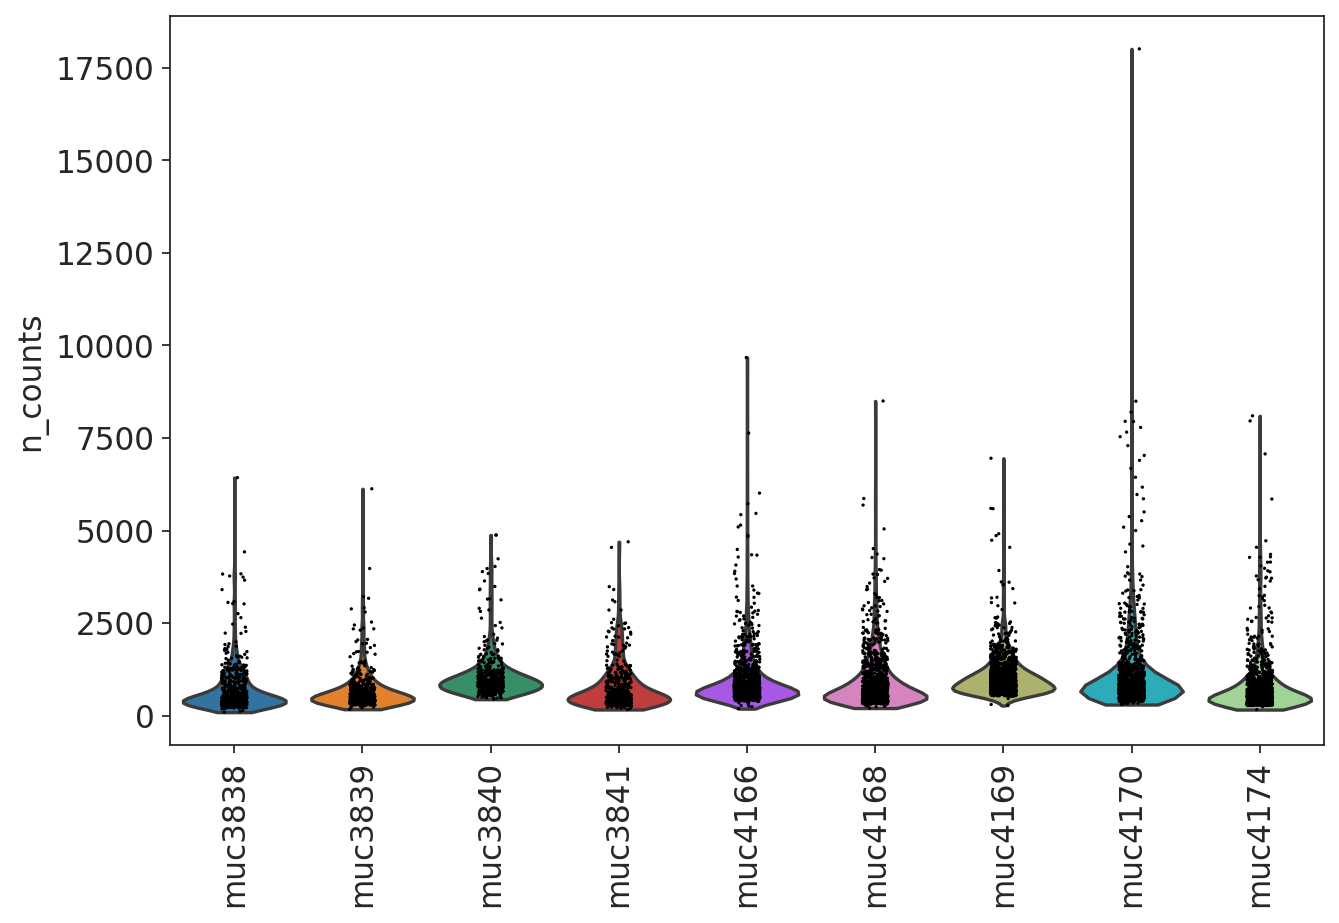

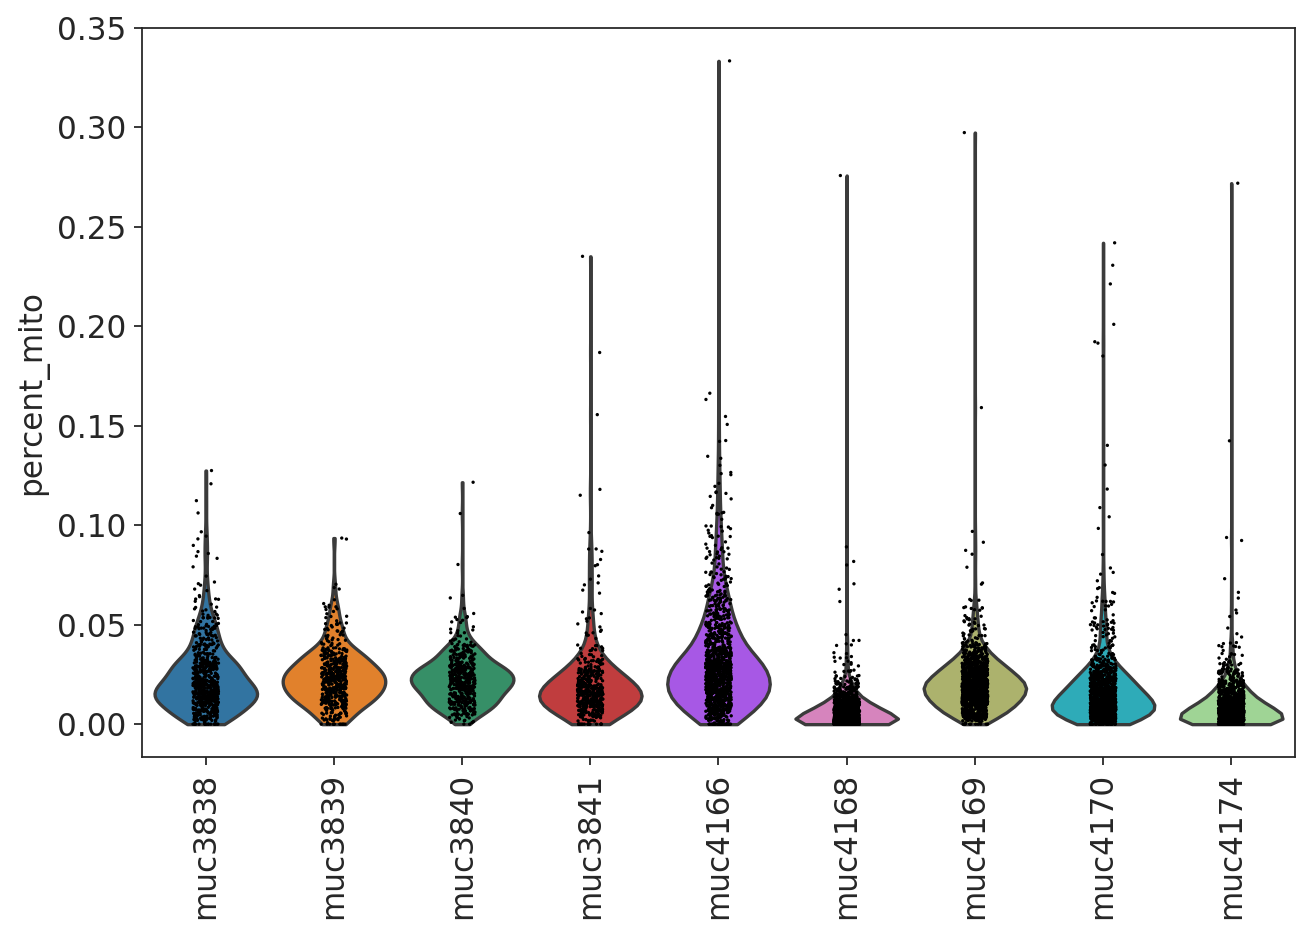

In [7]:
# Quality control - plot QC Metrics
plt.rcParams['figure.figsize'] = (8, 6)
sc.pl.violin(adata, "n_counts", groupby = "identifier", size = 1.5, log = False, rotation = 90)
sc.pl.violin(adata, "percent_mito", groupby = "identifier", size = 1.5, rotation = 90)

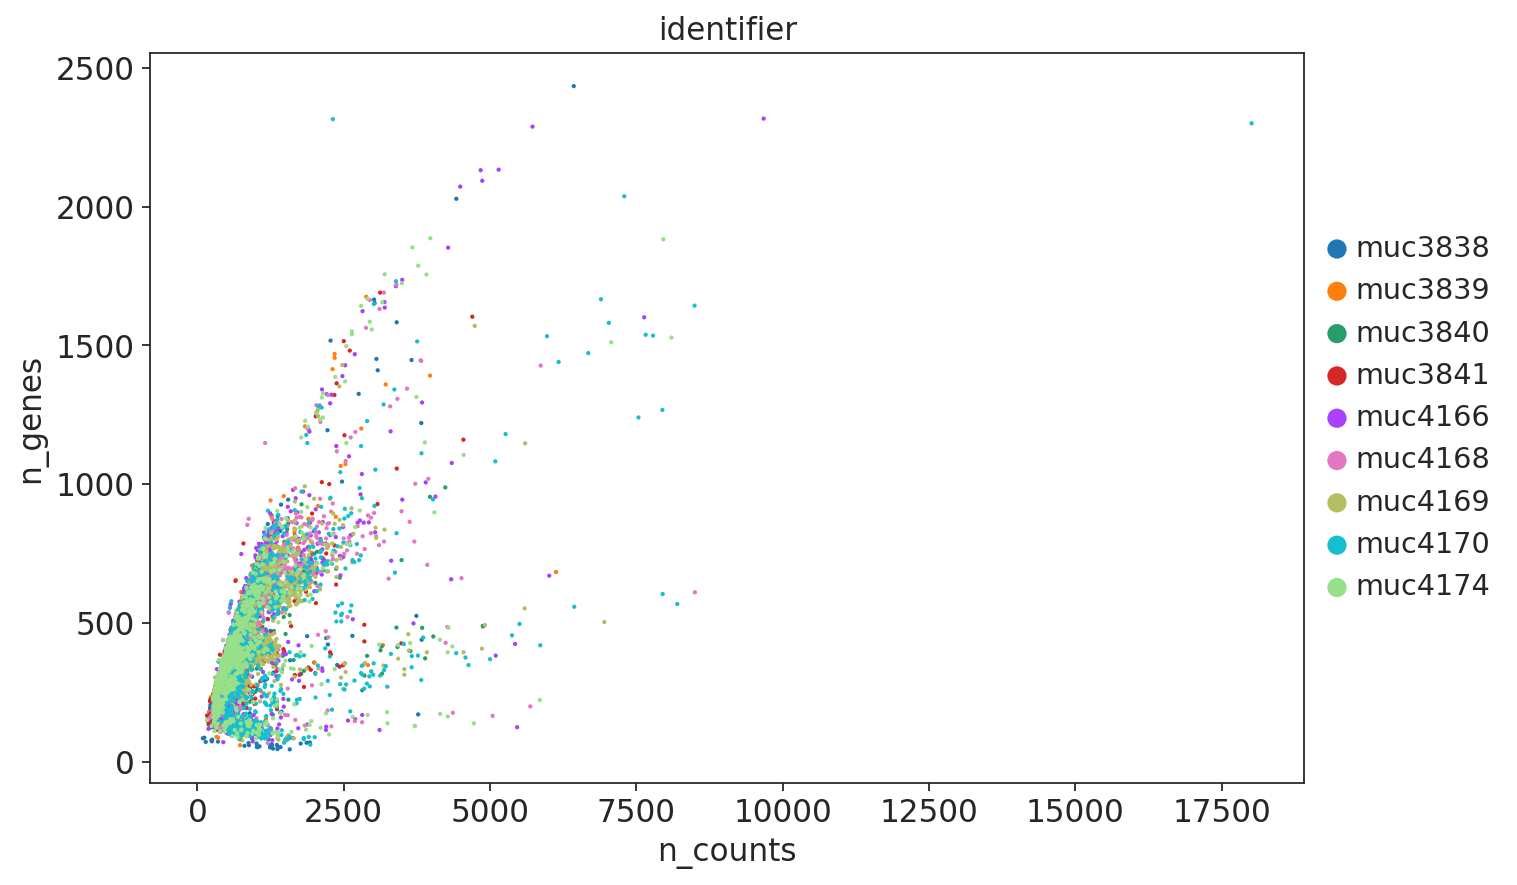

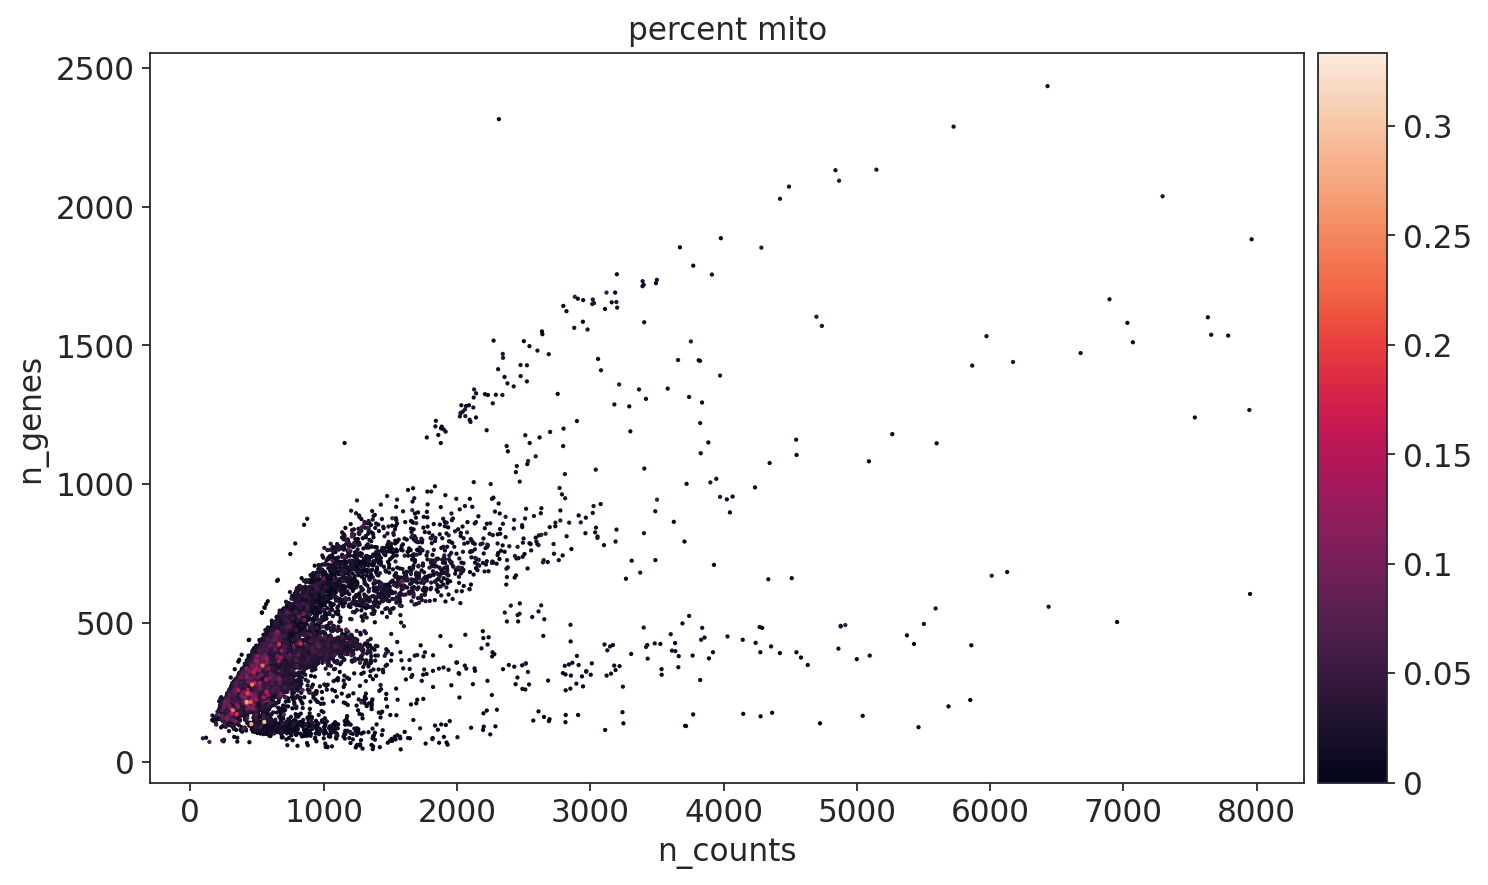

In [8]:
#Data quality summary plots
sc.pl.scatter(adata, "n_counts", "n_genes", color = "identifier")

## Zoom in to range
sc.pl.scatter(adata[adata.obs["n_counts"] < 8000], "n_counts", "n_genes", color = "percent_mito")

We can assess whether there are cells with unexpected summary statistics. For example, there is a cloud of points with many counts, but few genes. This cloud of cells may indicate empty droplets containing ambient RNA, or simply dying cells.

Cells with lower counts and genes tend to have a higher fraction of mitochondrial counts. These cells are likely under stress or are dying. When apoptotic cells are sequenced, there is less mRNA to be captured in the nucleus, and therefore fewer counts overall, and thus a higher fraction of counts fall upon mitochondrial RNA. If cells with high mitochondrial activity were found at higher counts/genes per cell, this would indicate biologically relevant mitochondrial activity.

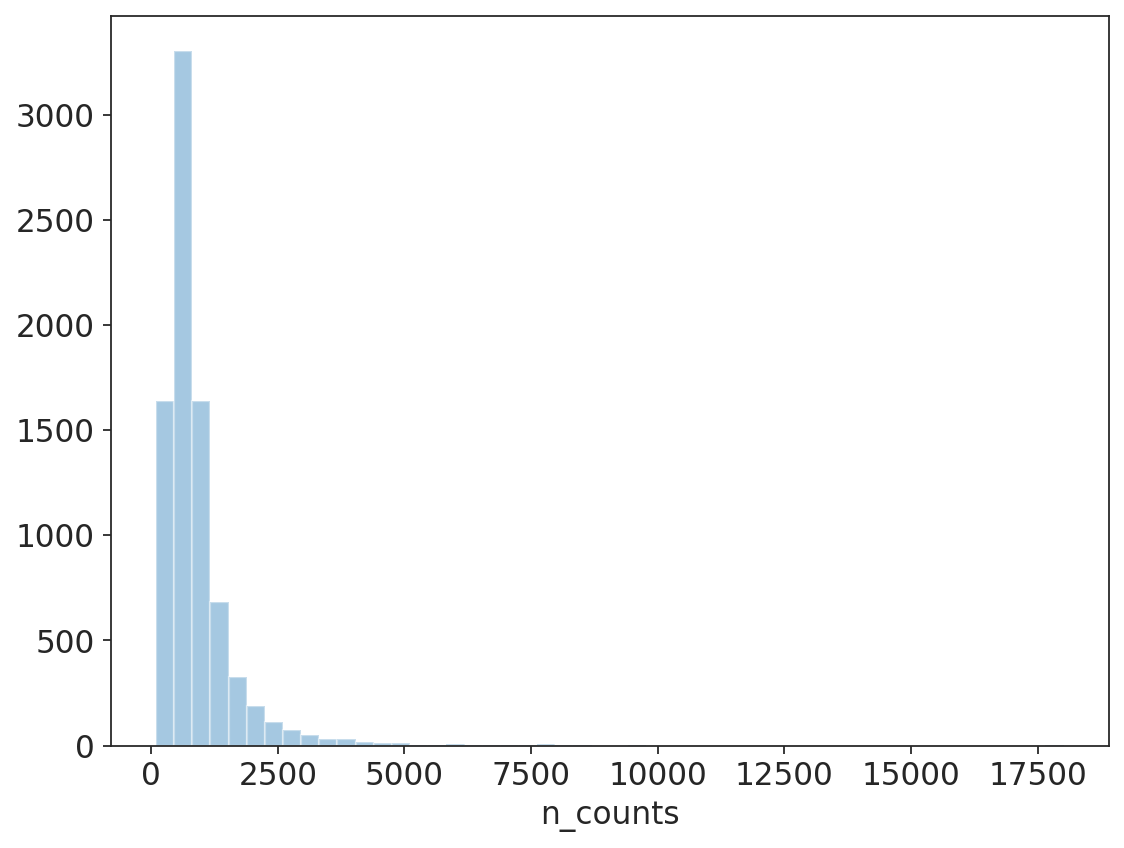

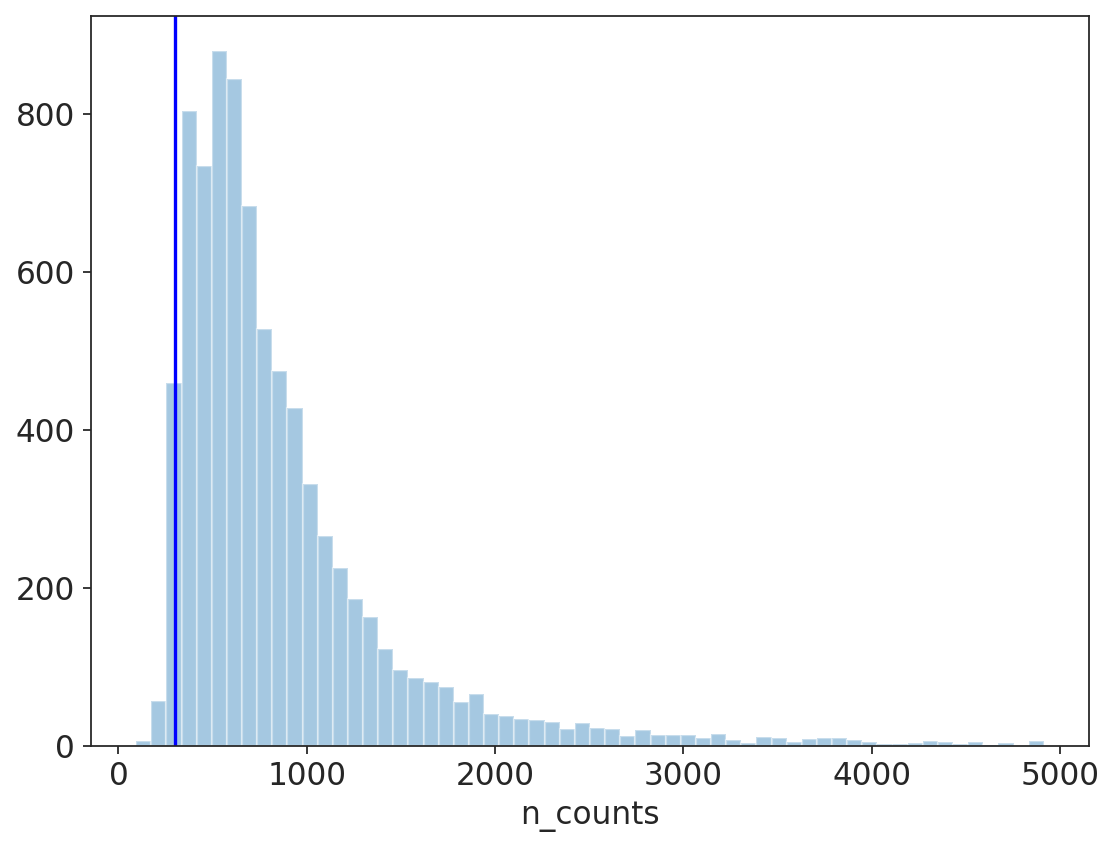

In [9]:
#Thresholding decision: counts
sb.distplot(adata.obs['n_counts'], kde = False)
plt.show()

sb.distplot(adata.obs['n_counts'][adata.obs['n_counts'] < 5000], kde = False, bins=60)
plt.axvline(300, color = "blue")
plt.show()

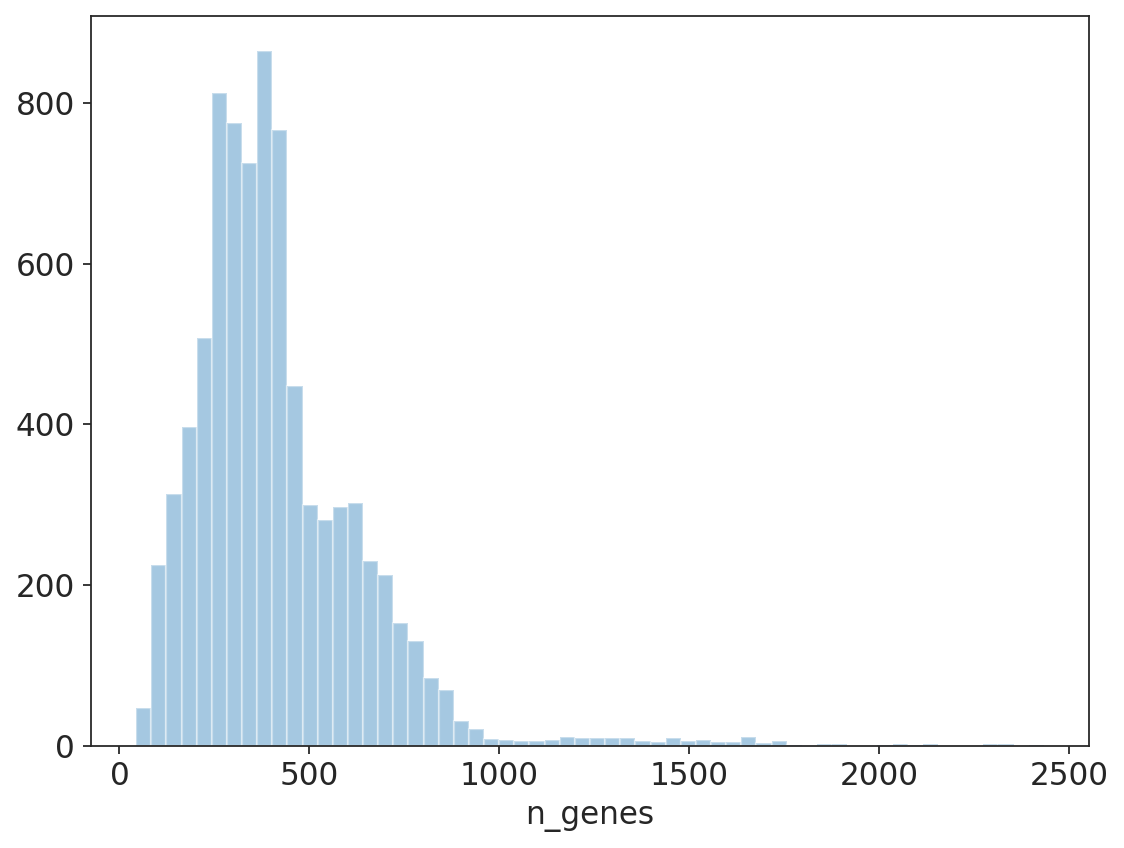

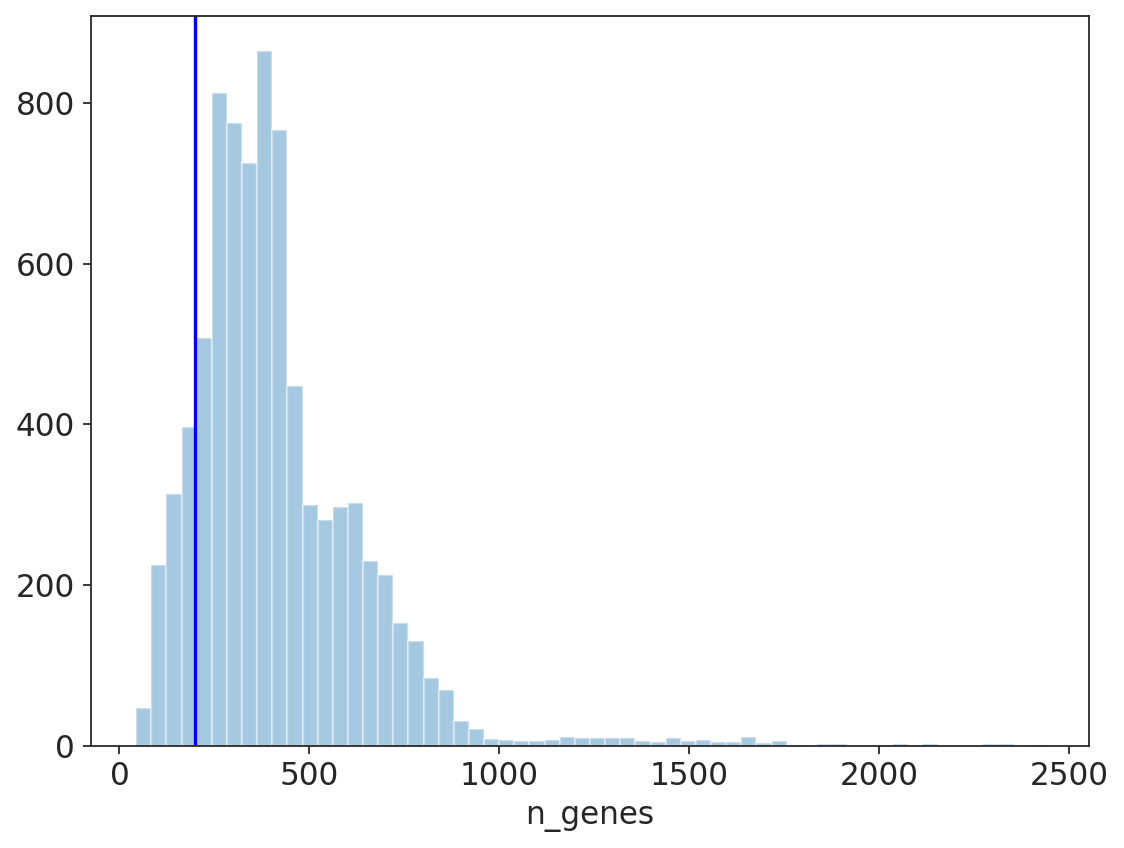

In [10]:
#Thresholding decision: genes
sb.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

sb.distplot(adata.obs['n_genes'][adata.obs['n_genes'] < 3000], kde = False, bins = 60)
plt.axvline(200, color = "blue")
plt.show()

In [11]:
## Actually do the Filtering
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 4000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 300)
sc.pp.filter_cells(adata, min_genes = 200)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_genes(adata, min_cells = 3)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs["percent_mito"] < 0.1]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

Total number of cells: 8152
Number of cells after max count filter: 8075
Number of cells after min count filter: 7027
Number of cells after gene filter: 7027
Number of cells after MT filter: 6984


The filtering is performed based on the thresholds we identified from the QC plots. Genes are also filtered if they are not detected in at least 3 cells. This reduces the dimensions of the matrix by removing 0 count genes and genes which are not sufficiently informative of the dataset. <br>
In general it is a good idea to be permissive in the early filtering steps, and then come back to filter out more stringently when a clear picture is available of what would be filtered out. 

### Quality Plots after Filtering

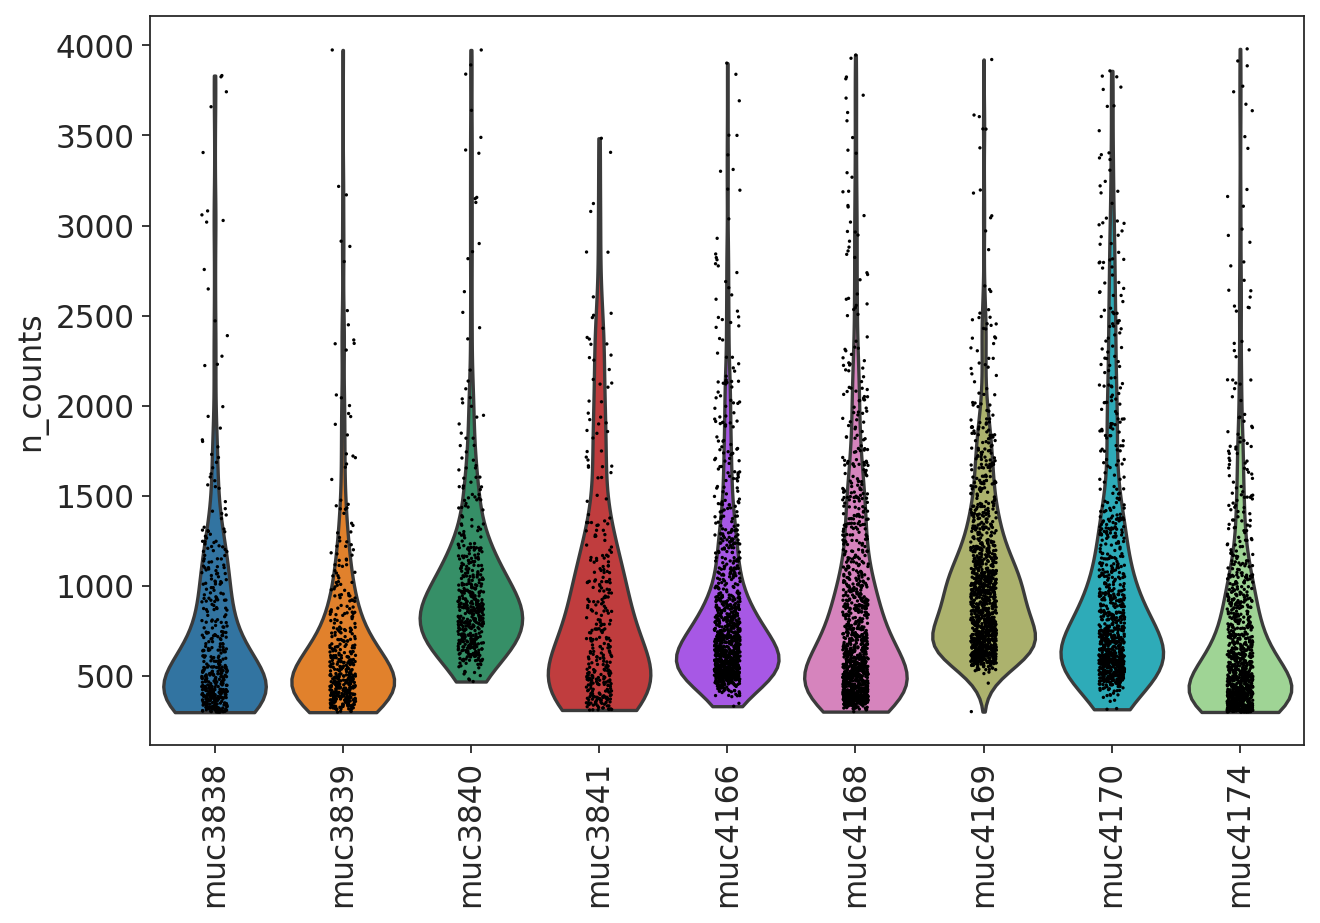

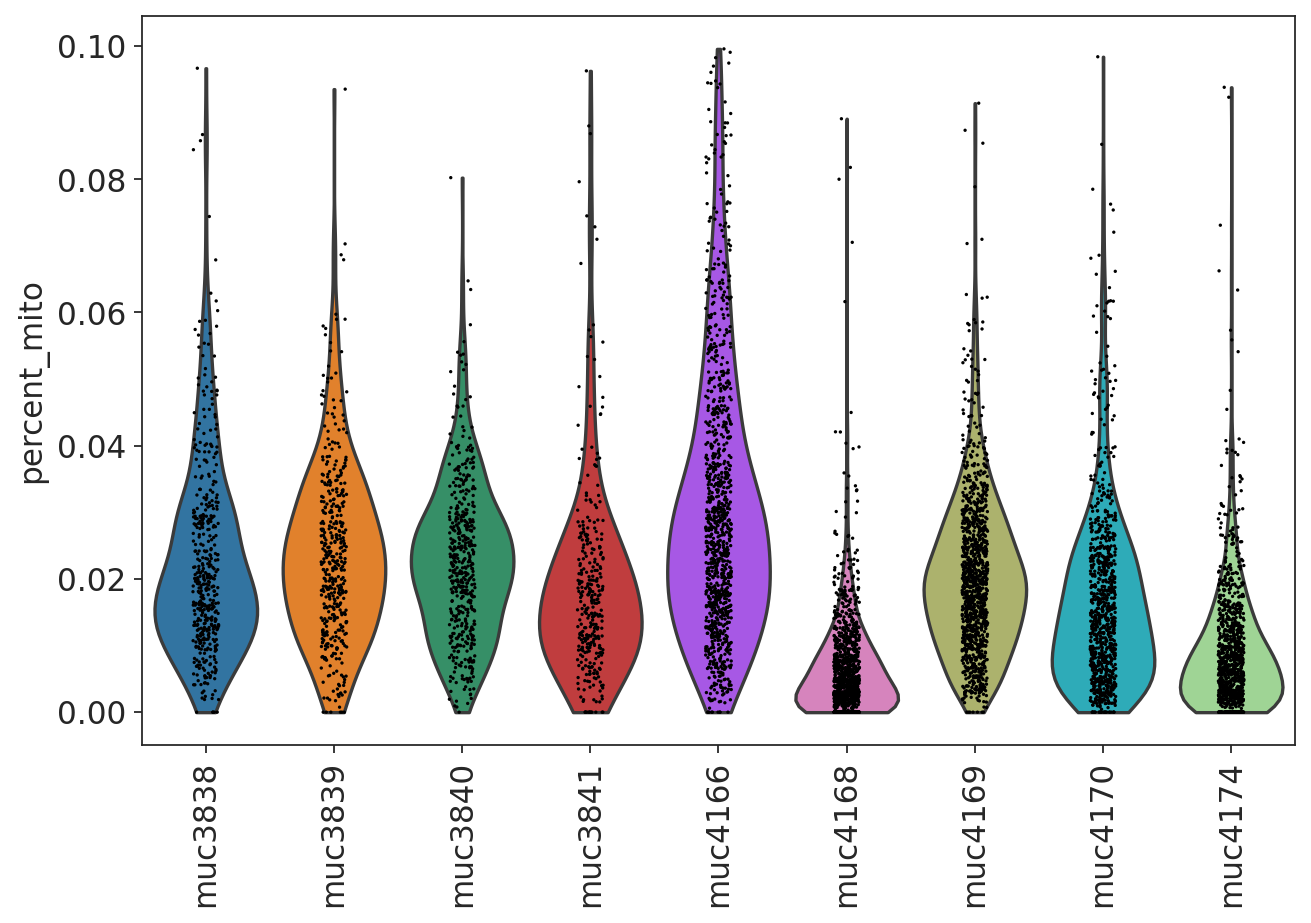

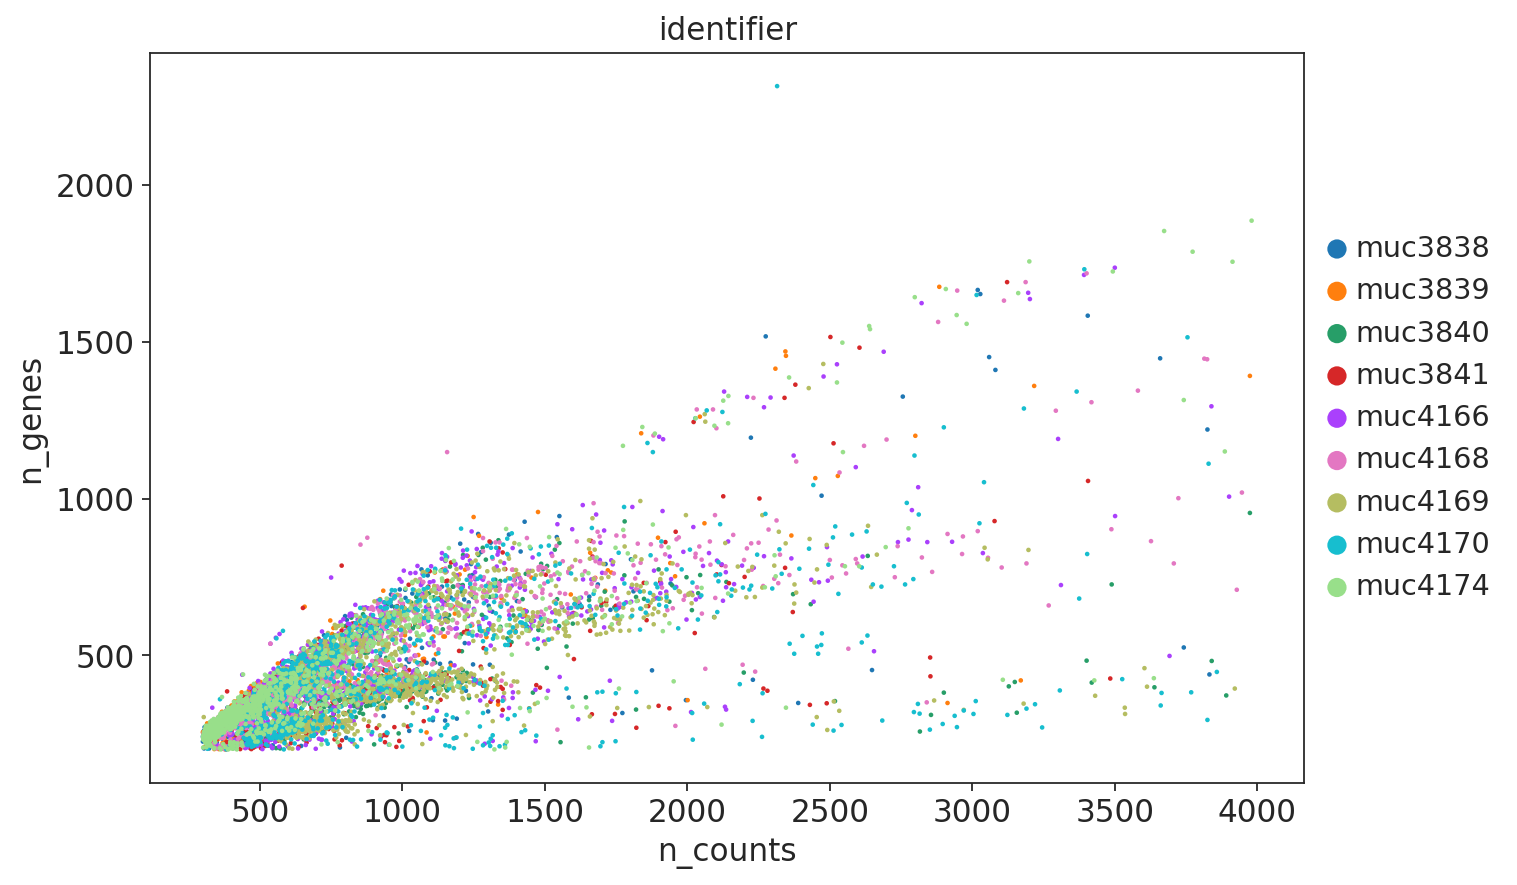

In [12]:
sc.pl.violin(adata, "n_counts", groupby = "identifier", size = 1.5, rotation = 90)
sc.pl.violin(adata, "percent_mito", groupby = "identifier", size = 1.5, rotation = 90)
sc.pl.scatter(adata, "n_counts", "n_genes", color= "identifier")

In [13]:
## Summary Statistics after Filtering
info = pd.DataFrame(data = adata.obs["identifier"].cat.categories, columns = ["identifier"])
info["n_counts"] = adata.obs.groupby(["identifier"])["n_counts"].median().values
info["n_genes"] = adata.obs.groupby(["identifier"])["n_genes"].median().values
info["percent_mito"] = adata.obs.groupby(["identifier"])["percent_mito"].mean().values
info["n_cells"] = adata.obs.groupby(["identifier"])["n_genes"].size().values
info

identifier  n_counts  n_genes  percent_mito  n_cells
0    muc3838     525.5    349.5      0.022604      466
1    muc3839     536.0    365.0      0.023716      437
2    muc3840     888.0    413.0      0.022628      483
3    muc3841     696.5    357.5      0.018795      334
4    muc4166     692.0    421.0      0.030604     1058
5    muc4168     644.0    404.0      0.006875     1119
6    muc4169     921.0    436.0      0.020341     1154
7    muc4170     751.0    410.0      0.016610      915
8    muc4174     527.0    348.0      0.009389     1018

### Normalization and log Transformation
Up to this point the data is only available as a count matrix. Counts are representative of molecules that were captured in the scRNA-seq experiment. As not all mRNA molecules in a cell are captured, there is a variability in the total number of counts detected between cells that results from both the number of molecules that were in the cells, and the sampling. As we cannot assume that all cells contain an equal number of molecules (cell sizes can differ substantially), we have to estimate the number of molecules that were initially in the cells. We keep this data in the '.X' part of the AnnData object as it will be used to visualize gene expression and perform statistical tests such as computing marker genes for clusters.

In [14]:
#Keep the count data in a counts layer 
adata.layers["counts"] = adata.X.copy()

## Normalization (divide by total UMI counts per cell)
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

In [15]:
adata.layers["counts"][0:5, 0:10].todense()

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [16]:
adata.X[0:5, 0:10].todense()

matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.17807525, 0.        , 0.17807525,
         0.        , 0.17807525, 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.19012266, 0.        , 0.        , 0.        , 0.        ]],
       dtype=float32)

### Extract highly variable Genes

We extract highly variable genes (HVGs) to further reduce the dimensionality of the dataset and include only the most informative genes. Genes that vary substantially across the dataset are informative of the underlying biological variation in the data. As we only want to capture biological variation in these genes, we select highly variable genes after normalization and batch correction. HVGs are used for clustering, trajectory inference, and dimensionality reduction/visualization, while the full data set is used for computing marker genes, differential testing and visualizing expression values on the data.

In [17]:
sc.pp.highly_variable_genes(adata, flavor = "seurat", n_top_genes = 4000, batch_key = "identifier")
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))


 Number of highly variable genes: 4000


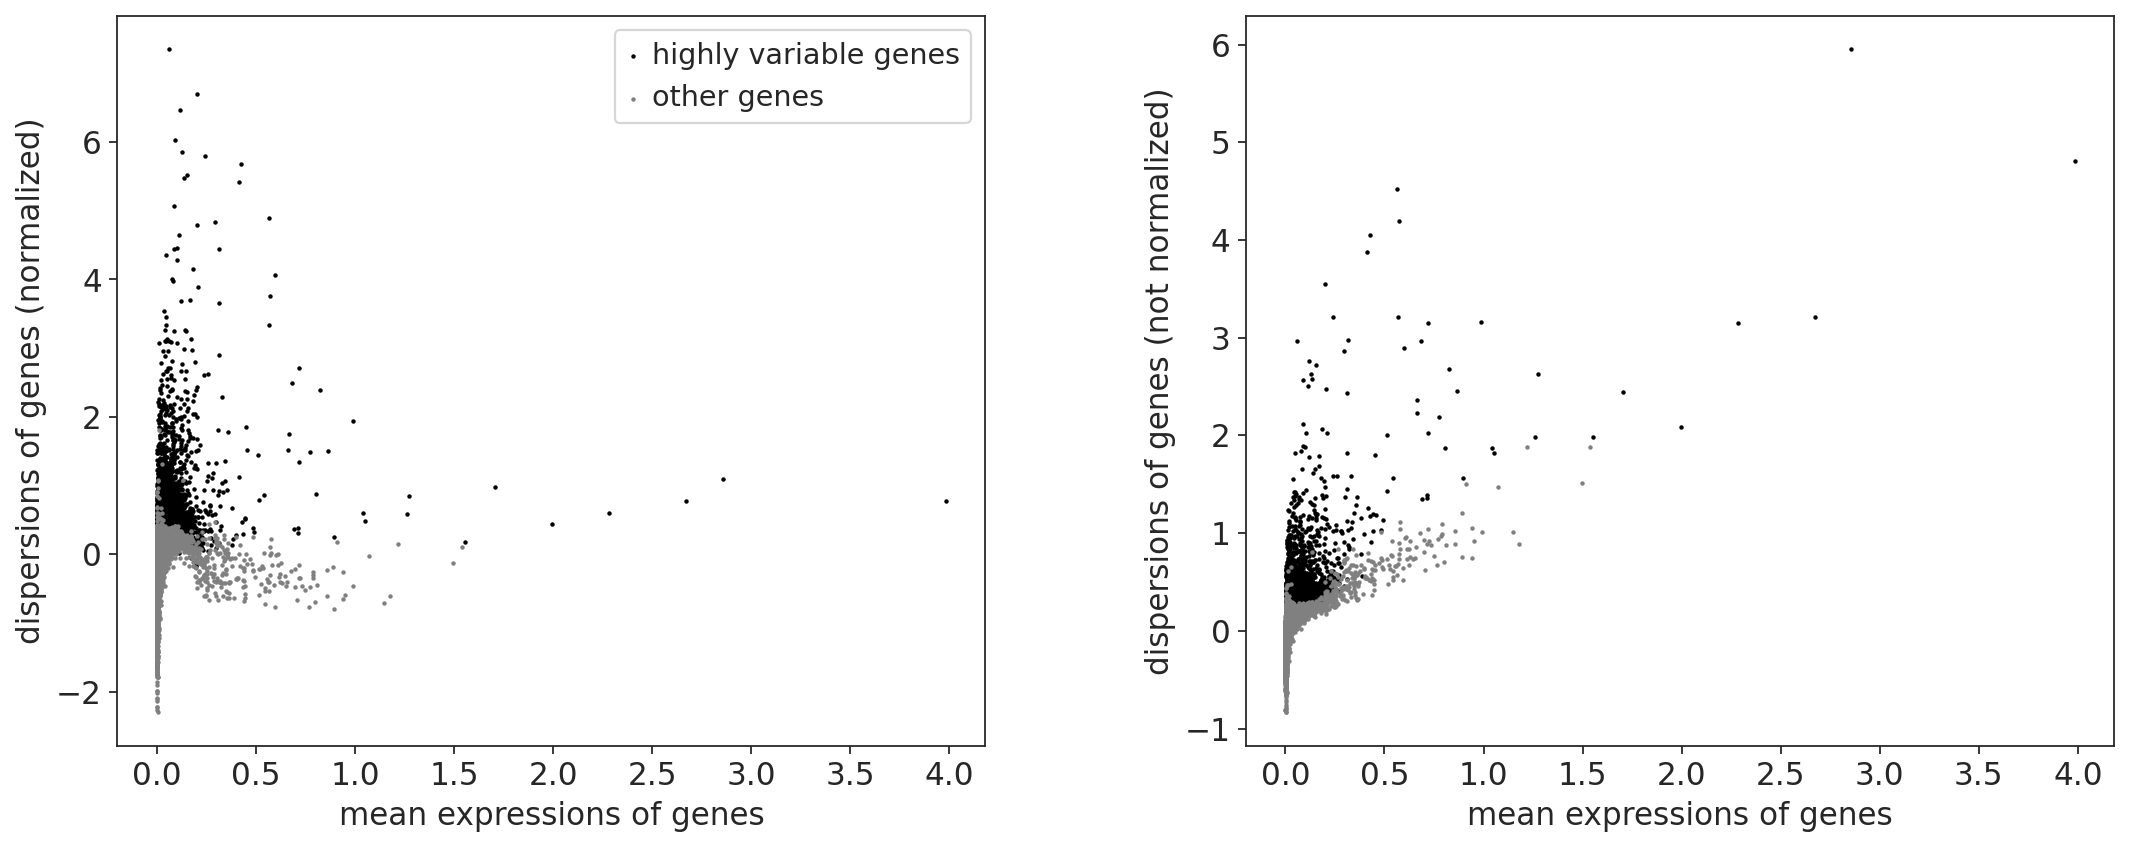

In [18]:
sc.pl.highly_variable_genes(adata)

Highly variable gene information is stored automatically in the adata.var['highly_variable'] field. The dataset now contains:

- log-normalized data in adata.X
- highly variable gene annotations in adata.var['highly_variable']

### Dimensionality Reduction using Principal Component Analysis
Visualizing scRNA-seq data is the process of projecting a high-dimensional matrix of cells and genes into a few coordinates such that every cell is meaningfully represented in a two-dimensional graph. Tt is a good idea to look at several visualizations and decide which visualization best represents the aspect of the data that is being investigated. <br>
Overall t-SNE visualizations have been very popular in the community, however the recent UMAP algorithm has been shown to better represent the topology of the data.


In [19]:
adata.shape

(6984, 16963)

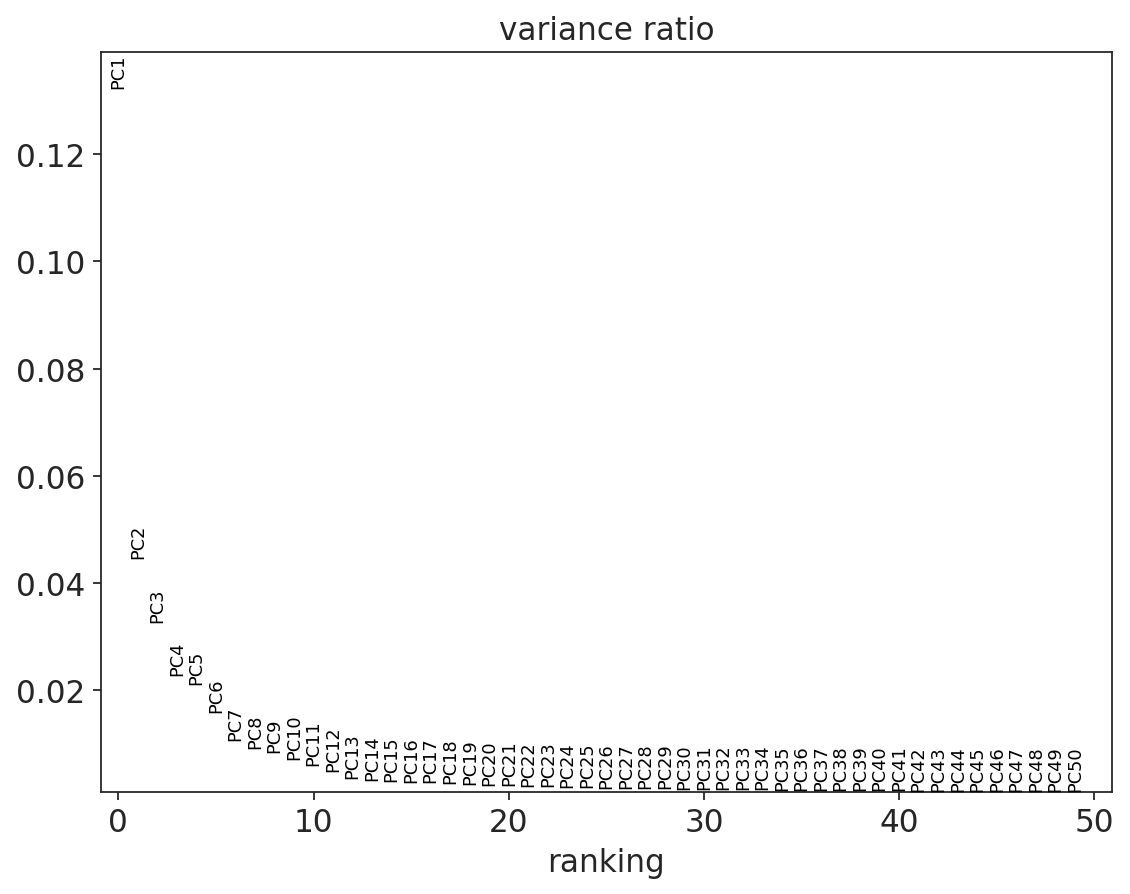

In [20]:
sc.pp.pca(adata, n_comps = 50, use_highly_variable = True)
sc.pl.pca_variance_ratio(adata, n_pcs = 50)

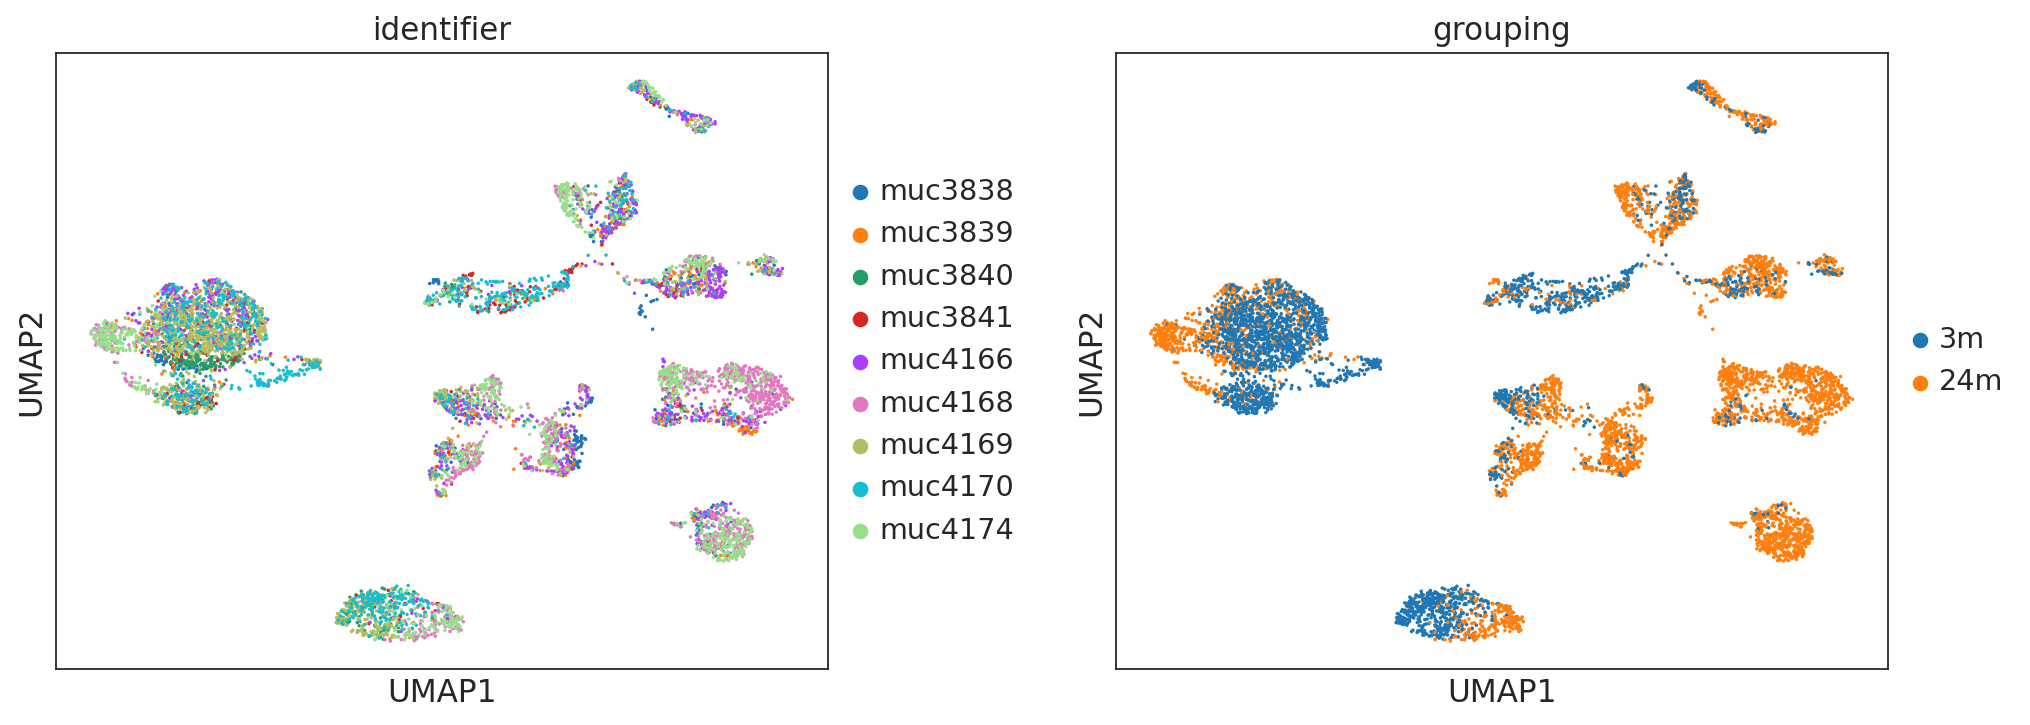

In [21]:
## Calculate nearest neighbourhood graph
sc.pp.neighbors(adata, n_pcs = 20, n_neighbors = 30)

## 2D embedding using UMAP
plt.rcParams['figure.figsize'] = (6, 5)
sc.tl.umap(adata)
sc.pl.umap(adata, color = ["identifier", "grouping"], wspace = 0.25, size = 10)

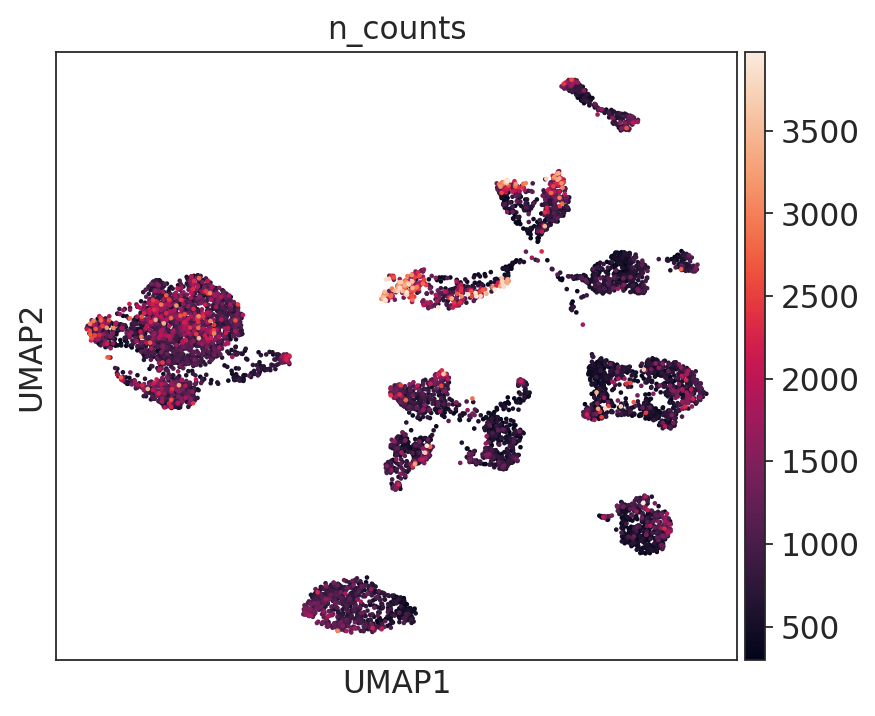

In [22]:
sc.pl.umap(adata, color = ["n_counts"], wspace = 0.2)

### Save the Plot

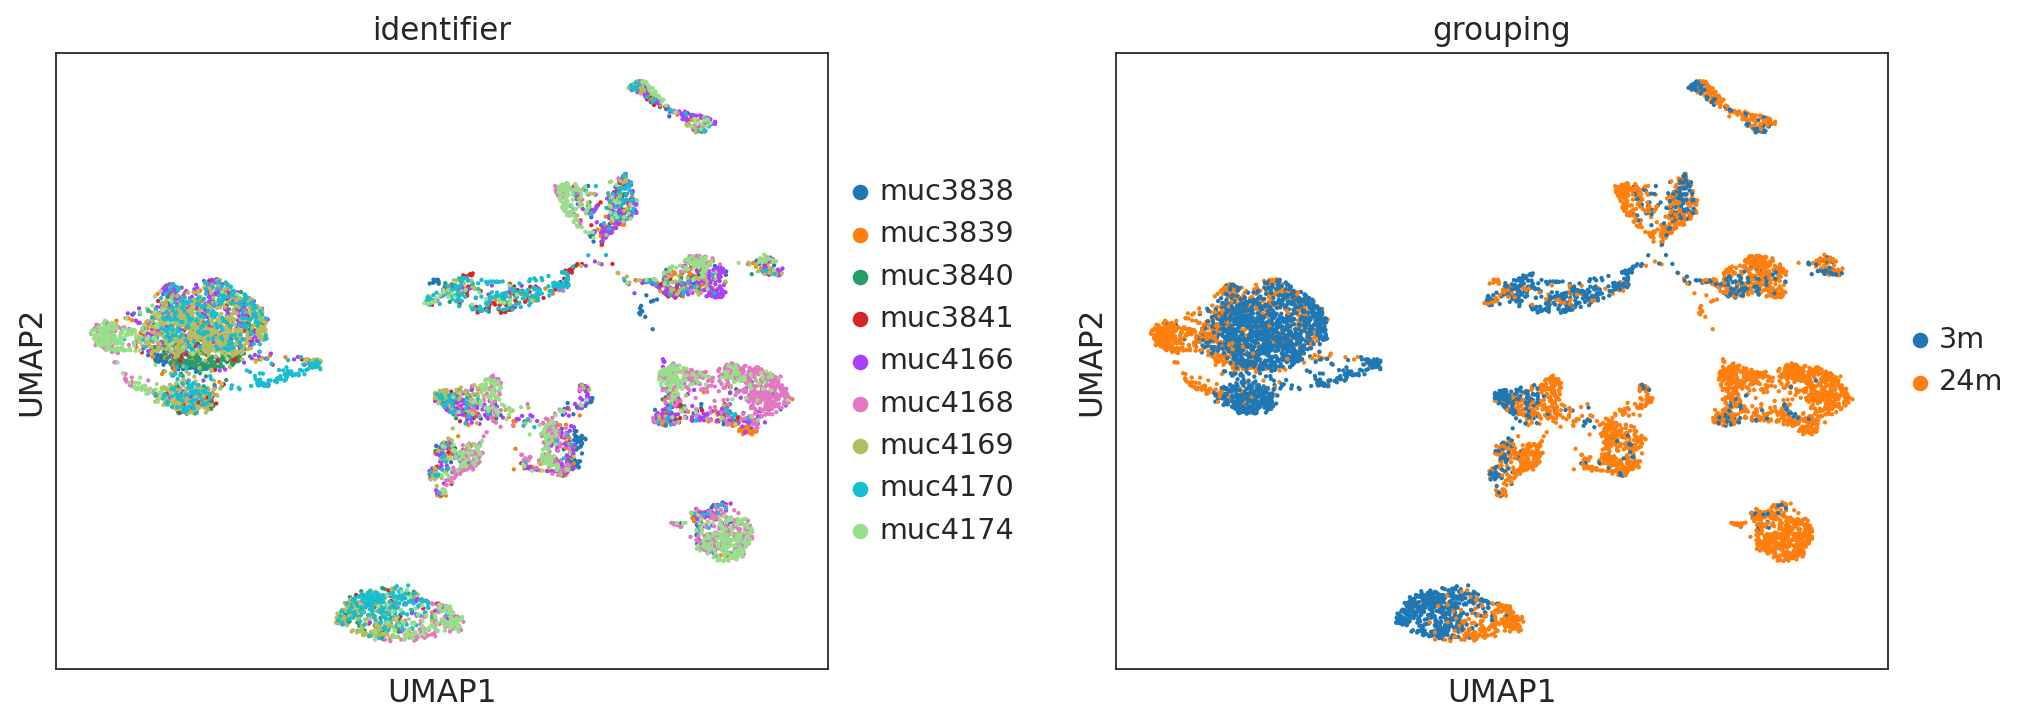

In [23]:
plt.rcParams['figure.figsize'] = (6, 5)
sc.pl.umap(adata, color = ["identifier", "grouping"], wspace = 0.25, size = 15, save = "_overview.pdf")

### Clustering
Clustering is a central component of the scRNA-seq analysis pipeline. To understand the data, we must identify cell types and states present. The first step of doing so is clustering. This modularity optimization is performed on the k-nearest-neighbour graph of cells in scRNA-seq analysis.  <br>
By changing the resolution parameter one can influence the number of clusters the algorithm finds. Investigating several resolutions allows us to select a clustering that appears to capture the main clusters in the visualization and can provide a good baseline for further subclustering of the data to identify more specific substructures.

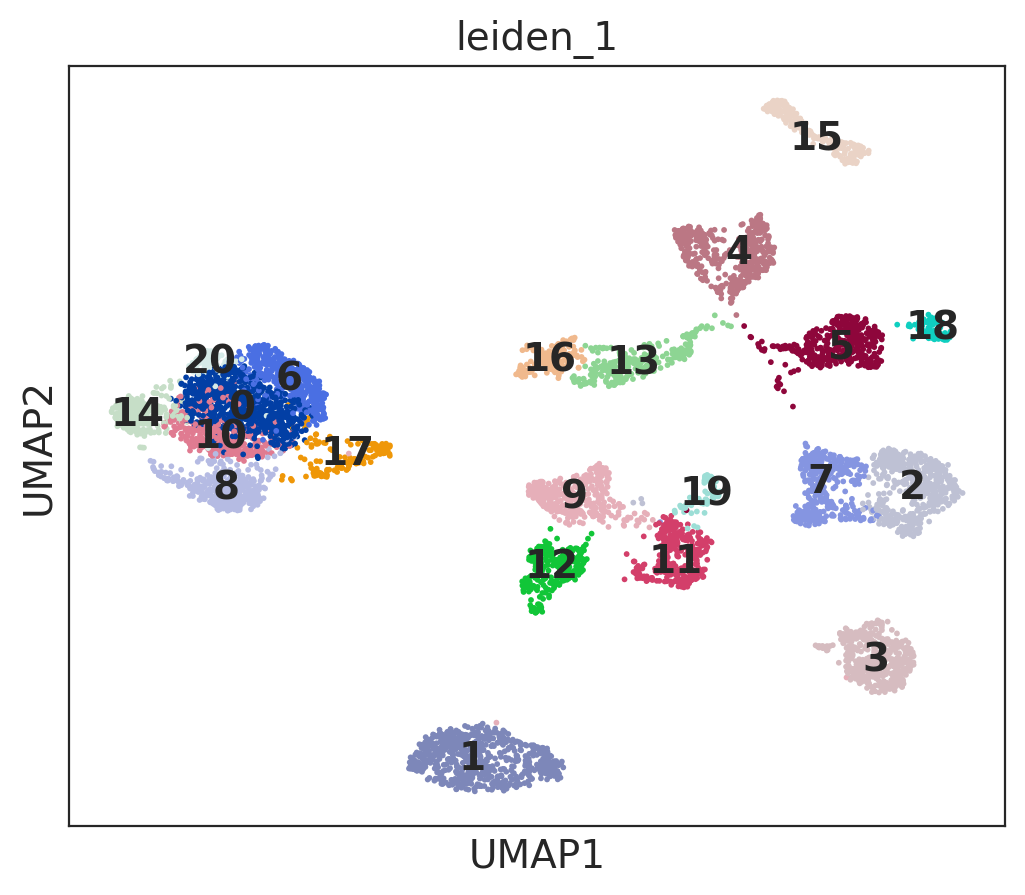

In [24]:
sc.tl.leiden(adata, resolution = 1, key_added = "leiden_1")

## Bigger Plot with labels on top of Cluster
sc.pl.umap(adata, color = "leiden_1", legend_loc = "on data", ax = plt.figure(figsize=(6, 5), dpi = 100).gca())

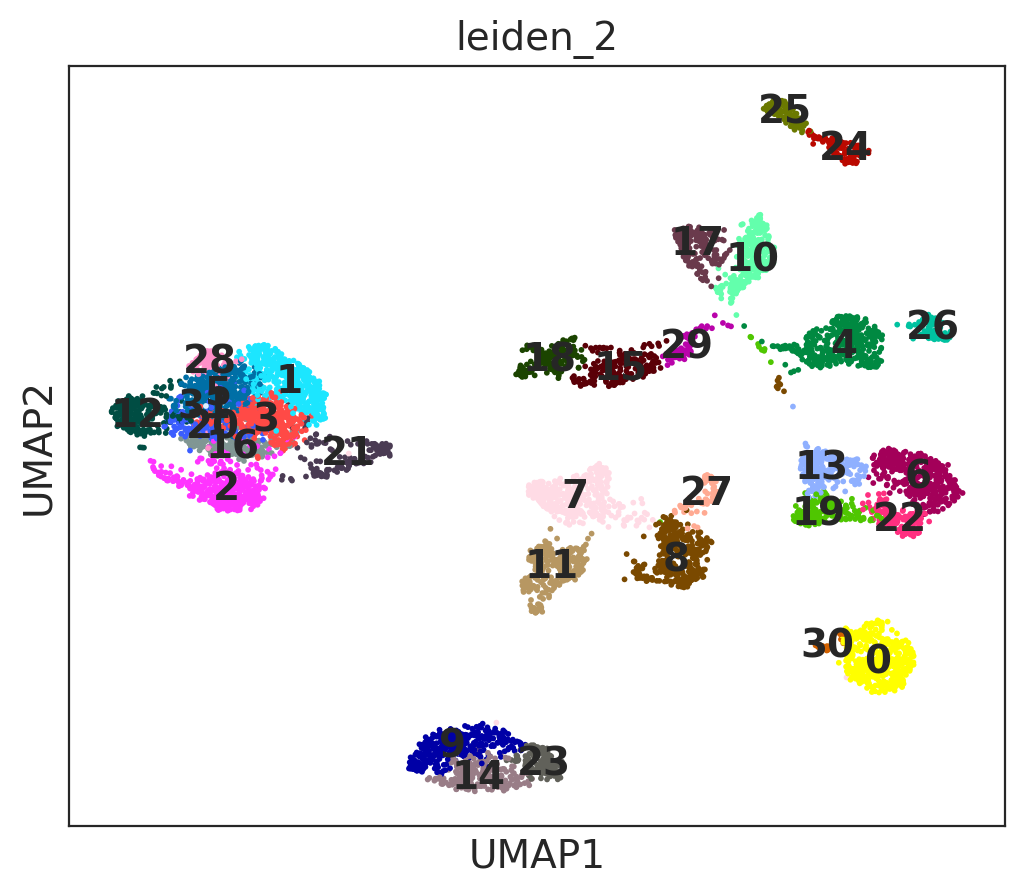

In [25]:
## Unsupervised Clustering at higher resolution
sc.tl.leiden(adata, resolution = 2, key_added = "leiden_2")
sc.pl.umap(adata, color = "leiden_2", legend_loc = "on data", ax = plt.figure(figsize=(6, 5), dpi = 100).gca())

One can also visualize expression of certain known marker genes by specifying the colour Parameter

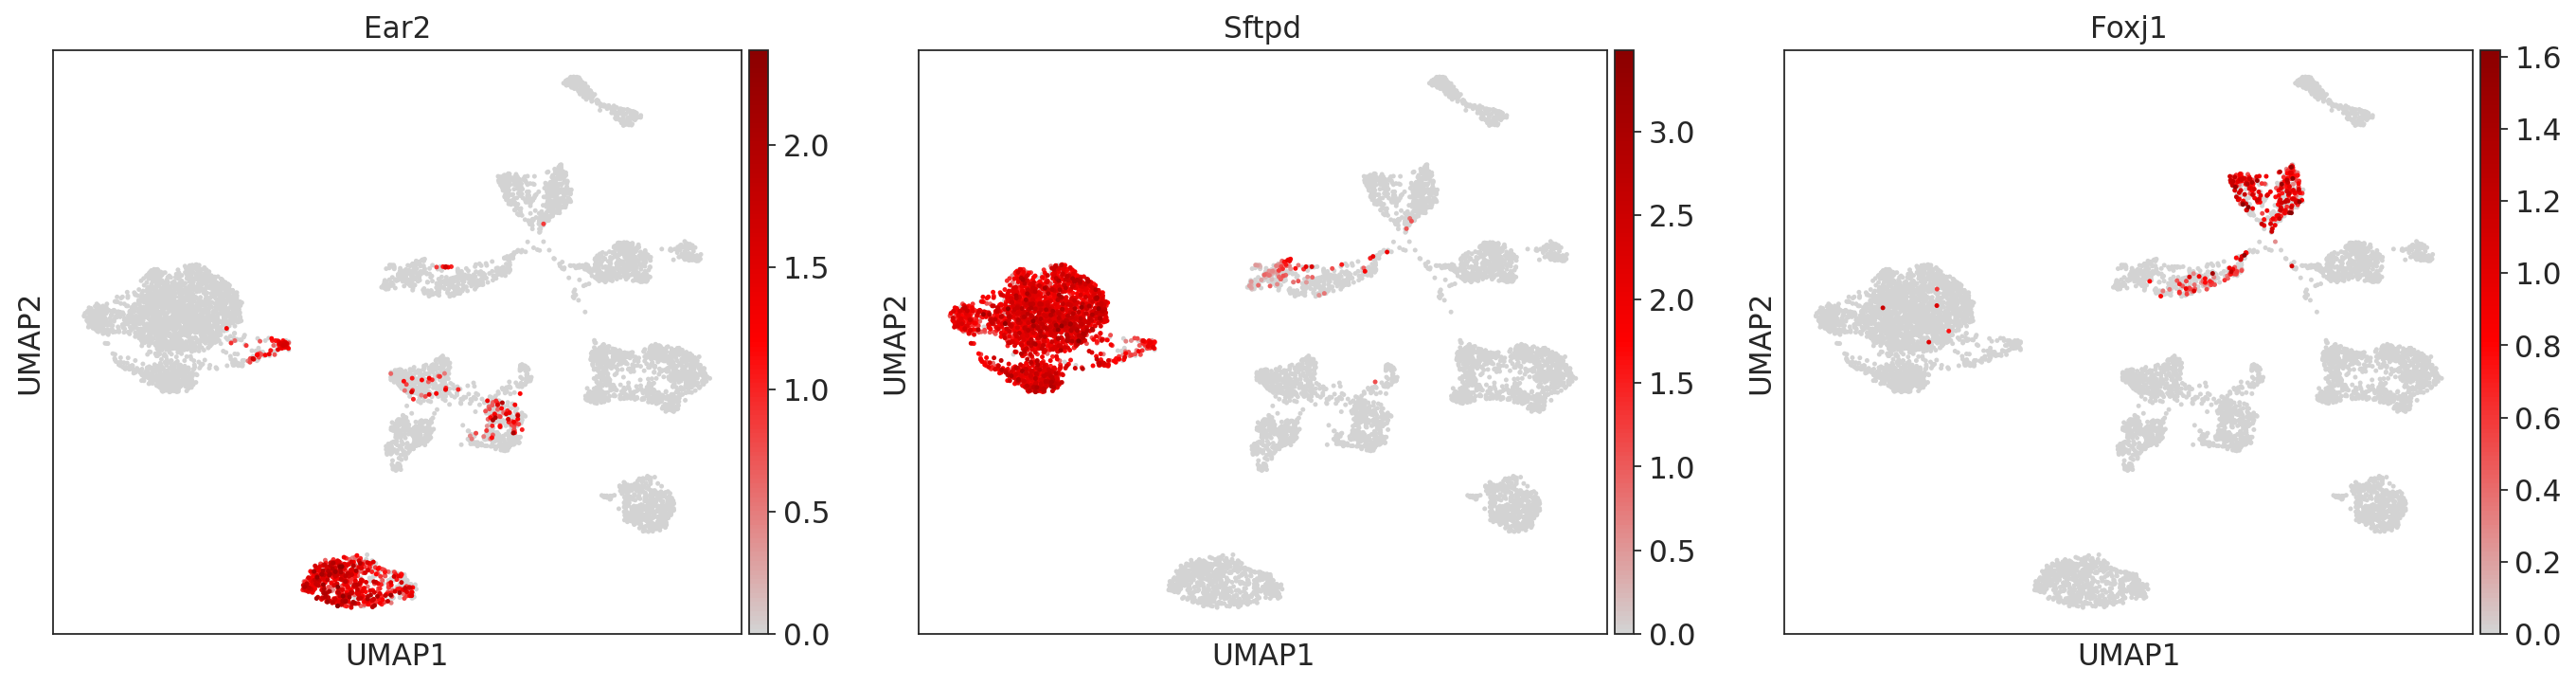

In [26]:
sc.pl.umap(adata, color = ["Ear2", "Sftpd", "Foxj1"], cmap = gray_red, size = 20)

### Find Marker Genes and Annotate Clusters
To annotate the clusters we obtained, we find genes that are up-regulated in the cluster compared to all other clusters (marker genes). The test is automatically performed on the .raw data set, which is uncorrected and contains all genes. All genes are taken into account, as any gene may be an informative marker.

In [27]:
sc.tl.rank_genes_groups(adata, groupby = "leiden_1")

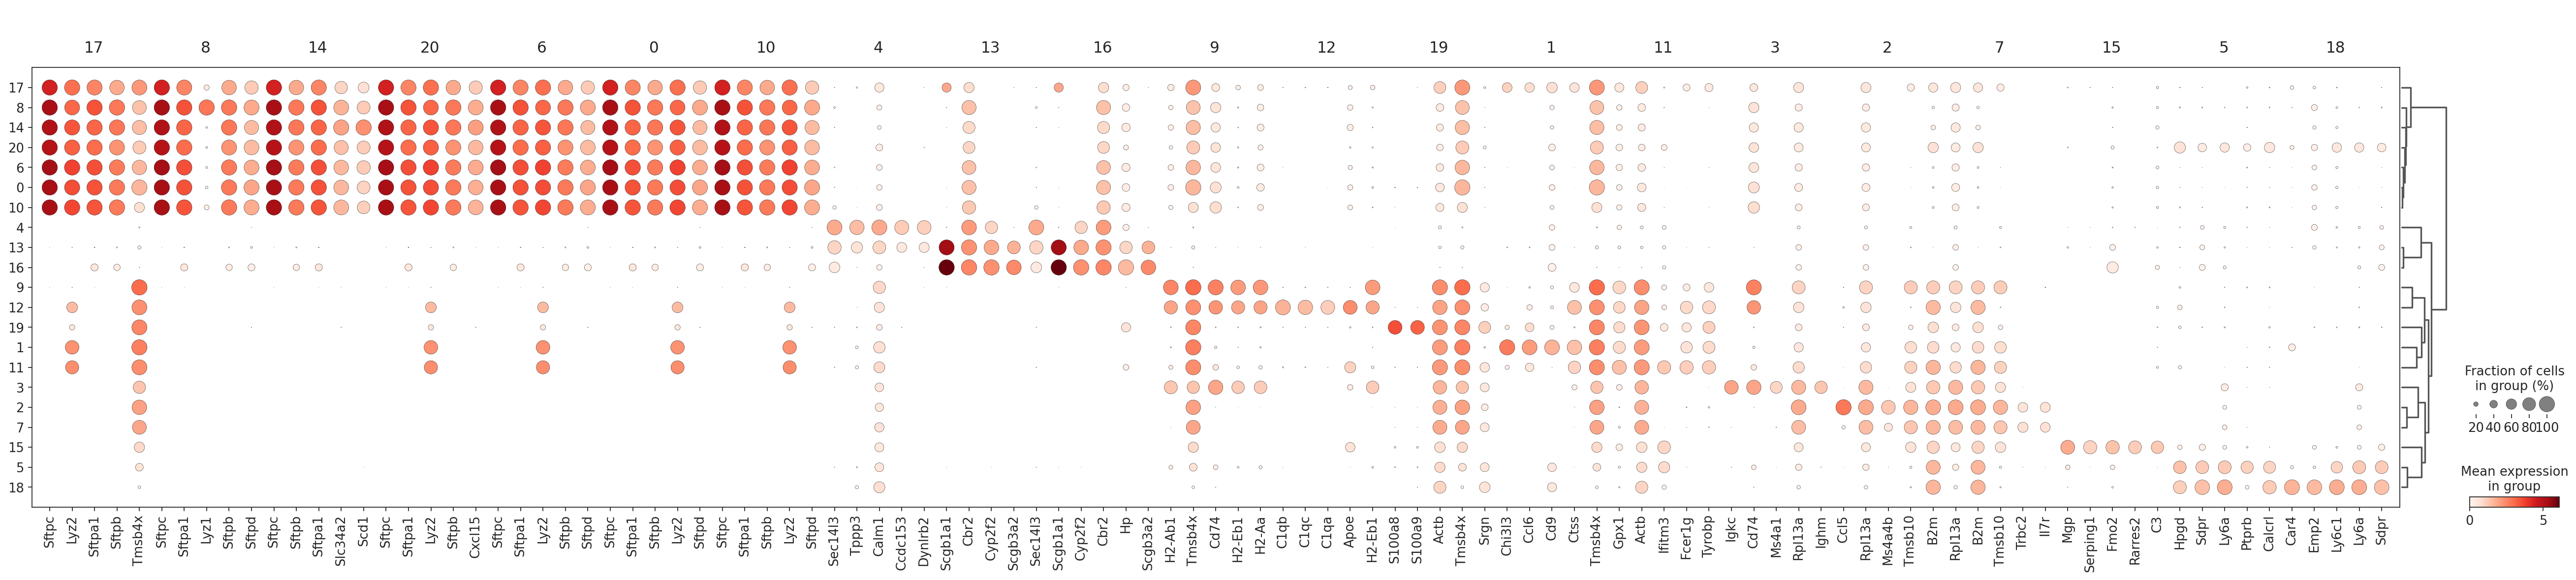

In [28]:
## Plot the first 10 genes per cluster
sc.pl.rank_genes_groups_dotplot(adata, n_genes = 5)

To further identify the clusters in ones data set, one can look at the overlap with a list of known marker genes.
In practice marker gene sets can be obtained from public databases such as Linnarson's mouse brain atlas, various Human Cell Atlas datasets, and other published reference atlases. It should be noted that marker genes may not always overlap as expected given that atlases tend to be investigated under wild-type conditions.

### Pick one or two cluster for which you could identify the cell type and annotate them in object

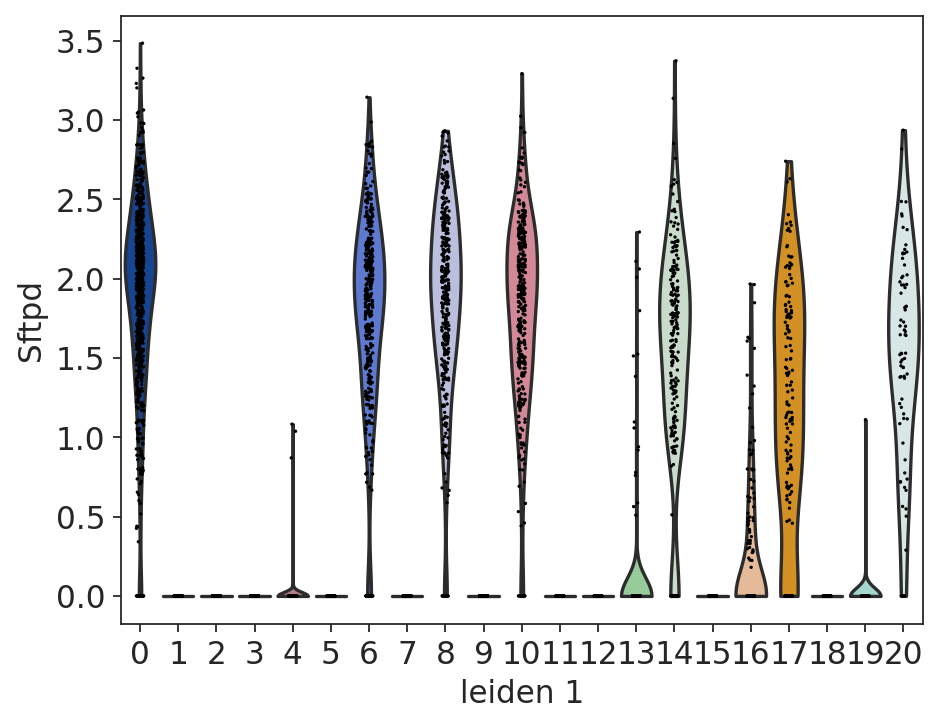

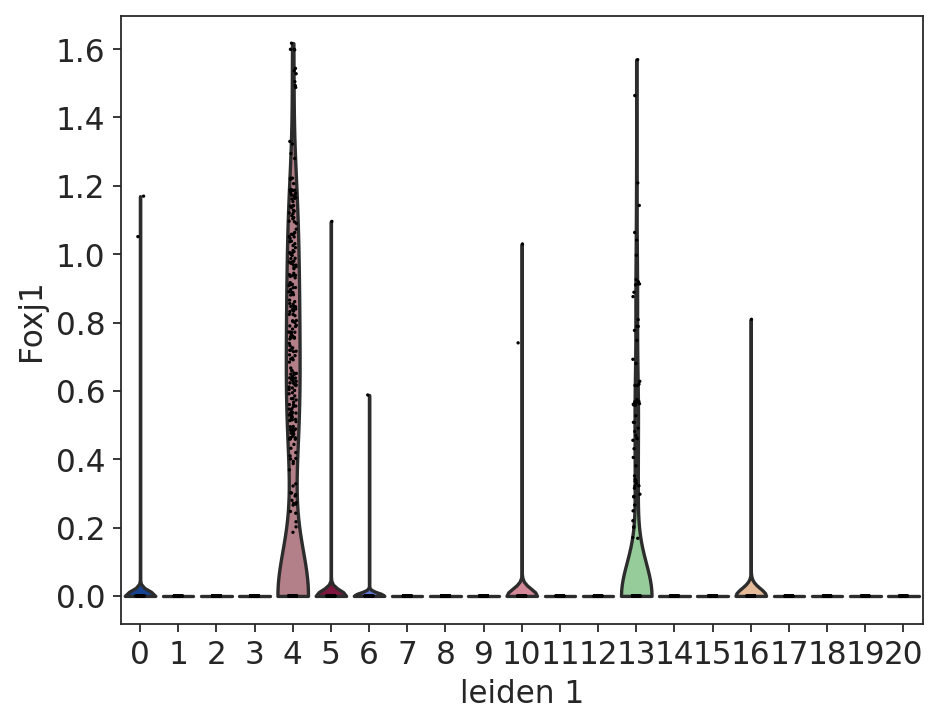

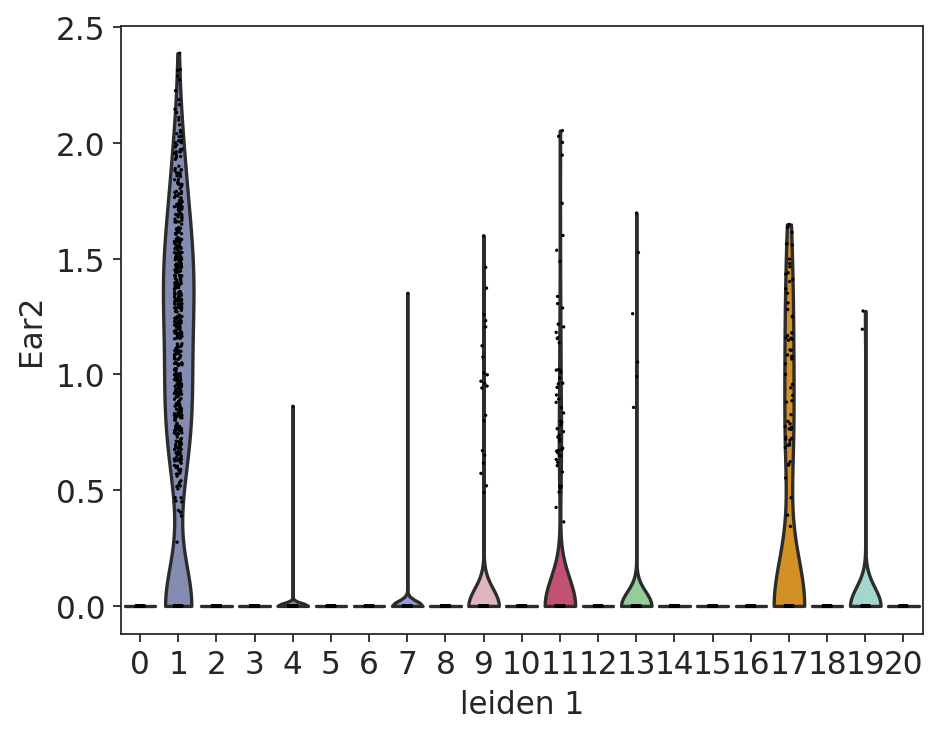

In [29]:
sc.pl.violin(adata, keys = ["Sftpd"], groupby = "leiden_1", size = 1.5)    ## AT2 cell marker
sc.pl.violin(adata, keys = ["Foxj1"], groupby = "leiden_1", size = 1.5)    ## Ciliated cell marker
sc.pl.violin(adata, keys = ["Ear2"], groupby = "leiden_1", size = 1.5)     ## Macrophage marker

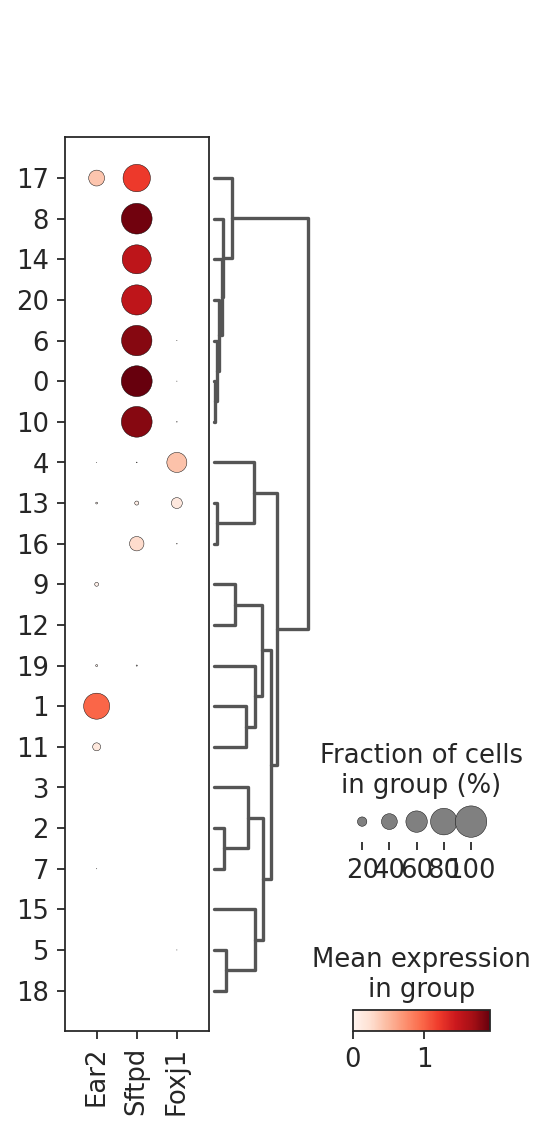

In [30]:
sc.pl.dotplot(adata, var_names = ["Ear2", "Sftpd", "Foxj1"], groupby = "leiden_1", dendrogram = True)

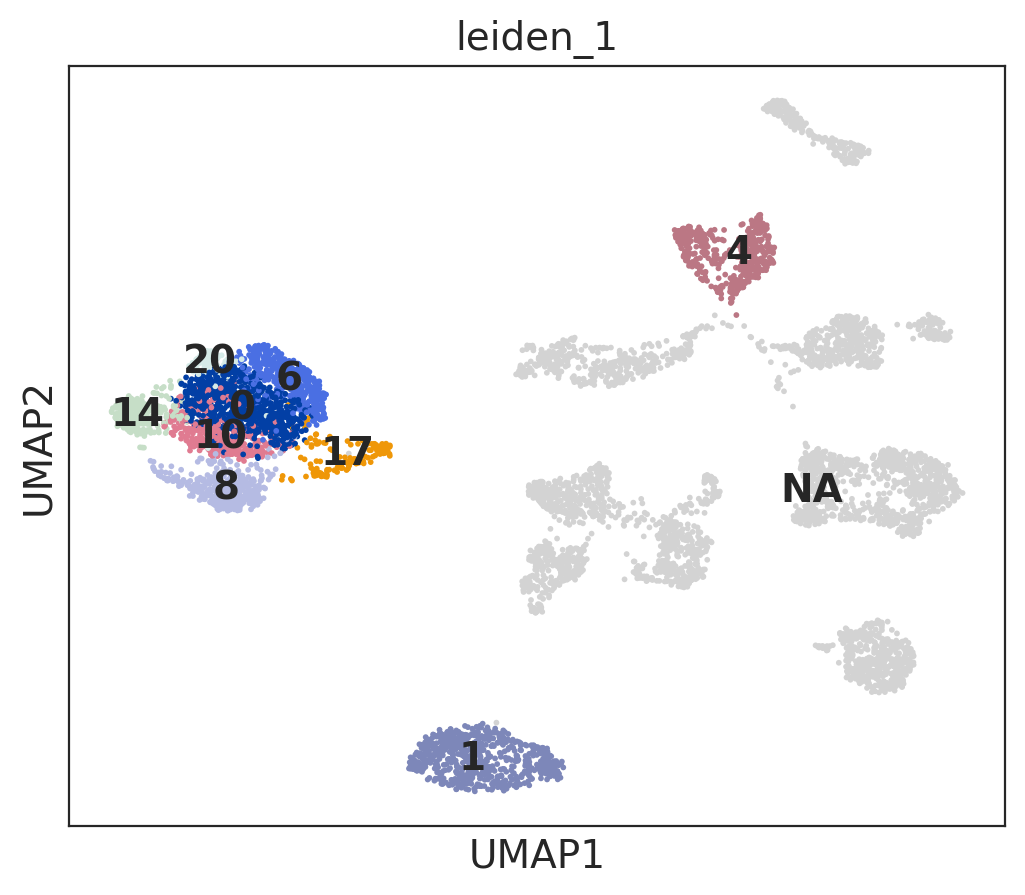

In [31]:
sc.pl.umap(adata, color = "leiden_1", legend_loc = "on data", ax = plt.figure(figsize=(6, 5), dpi = 100).gca(),
           groups = ["1", "17", "8", "14", "20", "6", "0", "10", "4"])

In [32]:
## you can even list more or less annotations in this dictionary
celltype_map = {"1": "Macrophages", "4": "Ciliated cells", "17": "AT2 cells", "8": "AT2 cells",
                "14": "AT2 cells", "20": "AT2 cells", "6": "AT2 cells", "0": "AT2 cells", "10": "AT2 cells",
                "17": "Doublets"}

adata.obs["cell_type"] = [celltype_map[leiden] if leiden in celltype_map.keys() else leiden
                          for leiden in adata.obs.leiden_1]

... storing 'cell_type' as categorical


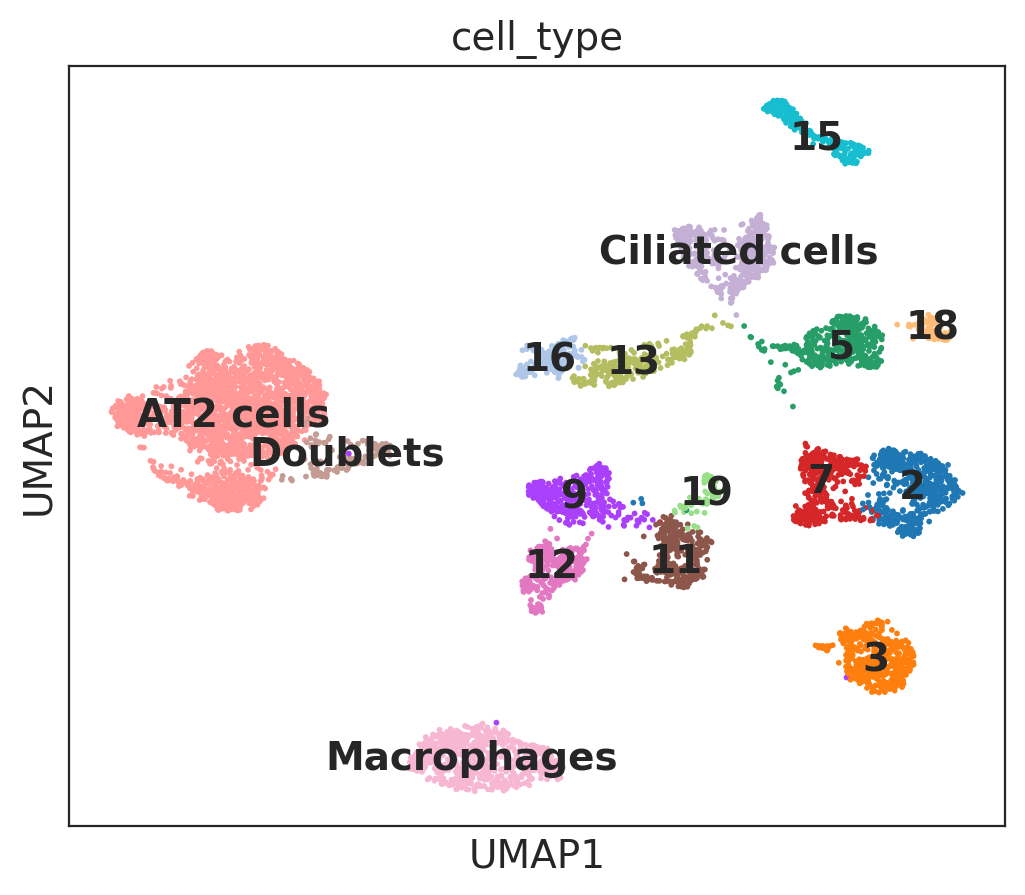

In [33]:
sc.pl.umap(adata, color = "cell_type", legend_loc = "on data", ax = plt.figure(figsize=(6, 5), dpi = 100).gca())

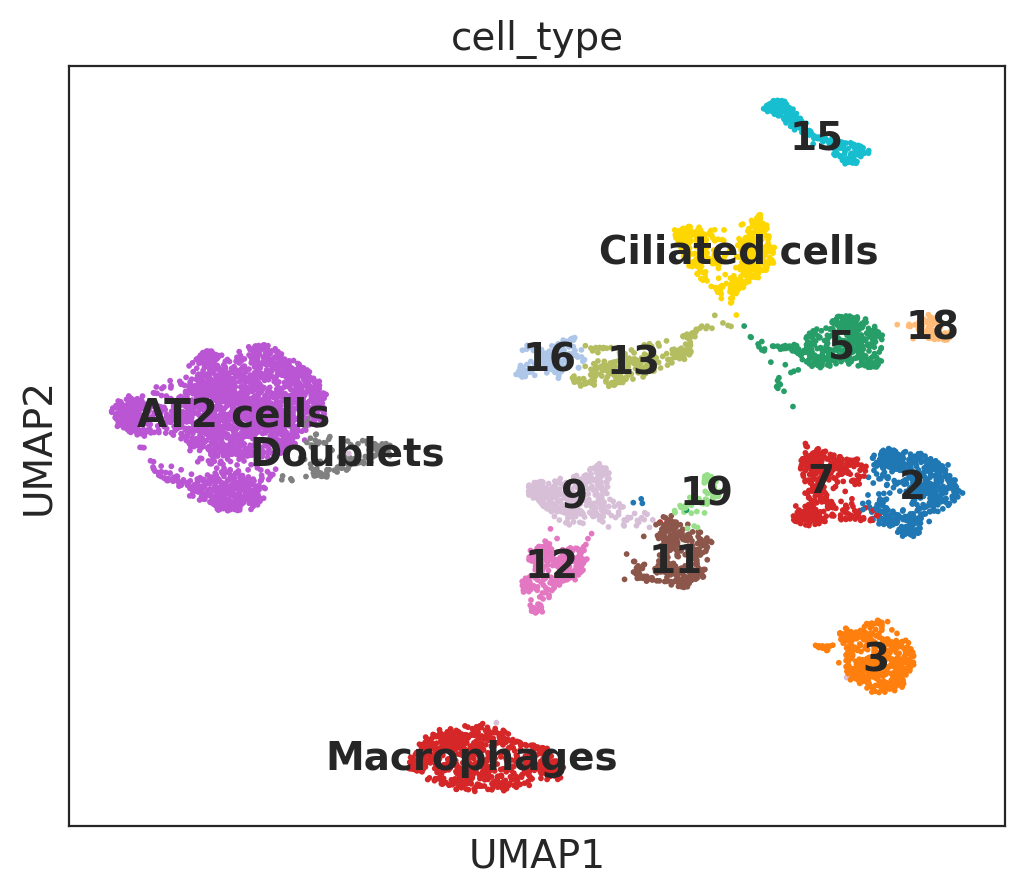

In [34]:
## Bonus: Recolour specific cell type
categories = adata.obs.cell_type.cat.categories
adata.uns["cell_type_colors"][np.where(categories == "AT2 cells")[0][0]] = "mediumorchid"
adata.uns["cell_type_colors"][np.where(categories == "Ciliated cells")[0][0]] = "gold"
adata.uns["cell_type_colors"][np.where(categories == "Macrophages")[0][0]] = "tab:red"
adata.uns["cell_type_colors"][np.where(categories == "Doublets")[0][0]] = "gray"
adata.uns["cell_type_colors"][np.where(categories == "9")[0][0]] = "thistle"

sc.pl.umap(adata, color = "cell_type", legend_loc = "on data", ax = plt.figure(figsize=(6, 5), dpi = 100).gca())

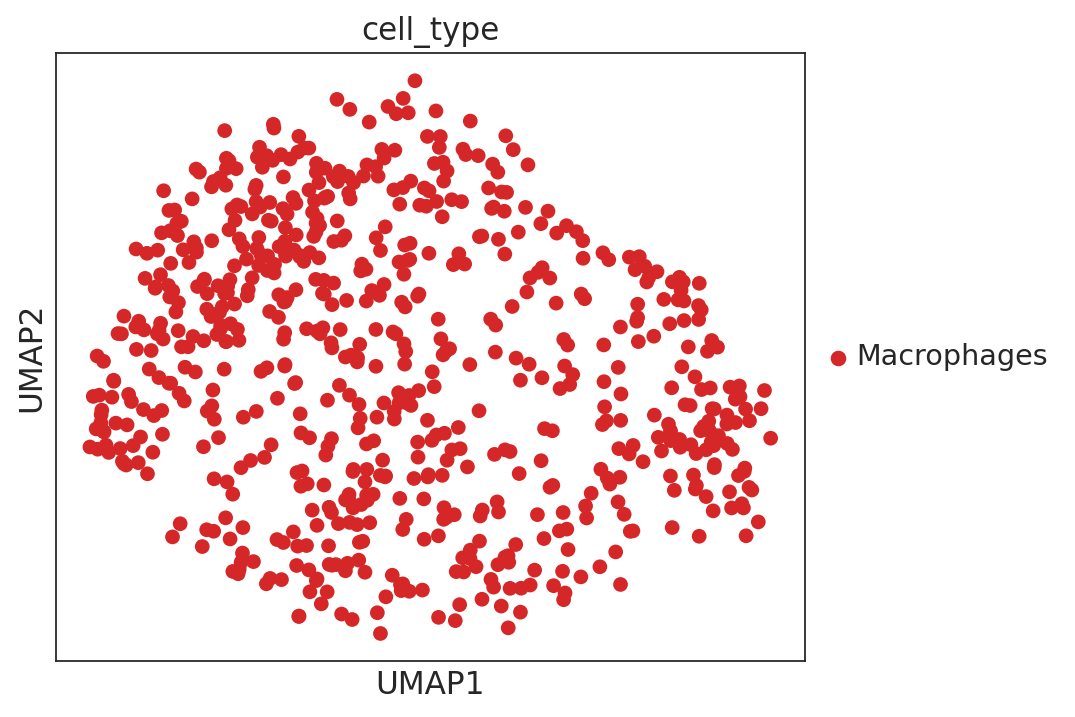

In [35]:
sub = adata[adata.obs.cell_type.isin(["Macrophages"])].copy()
sc.pl.umap(sub, color = "cell_type")

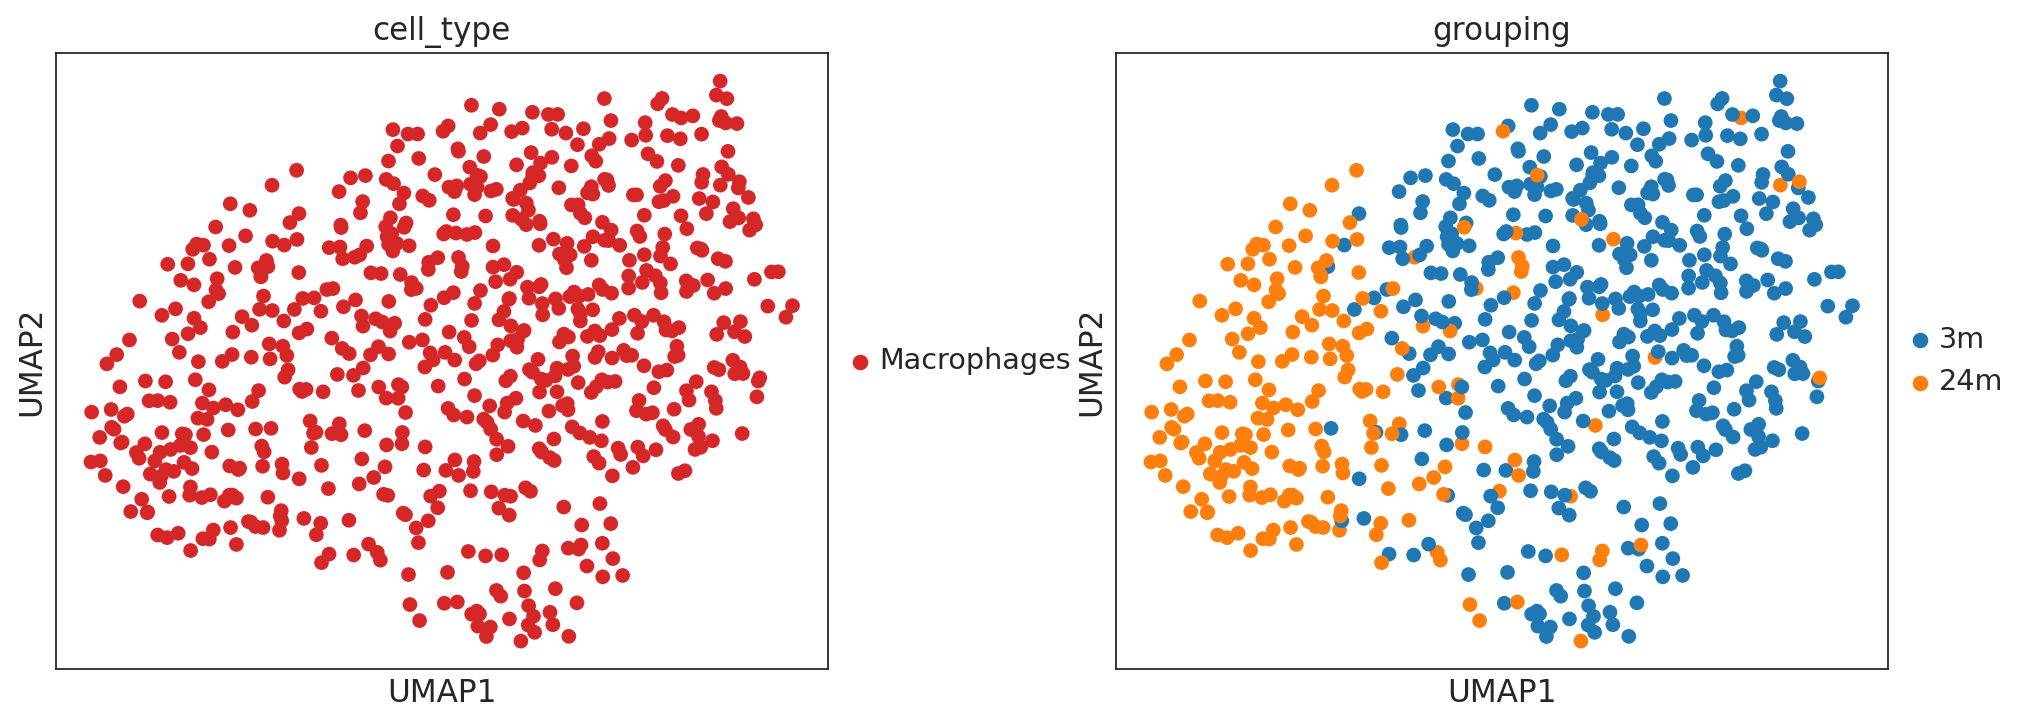

In [36]:
sc.pp.pca(sub, n_comps = 50, use_highly_variable = True)
sc.pp.neighbors(sub, n_pcs = 20, n_neighbors = 30)

sc.tl.umap(sub)
sc.pl.umap(sub, color = ["cell_type", "grouping"], wspace = 0.25)

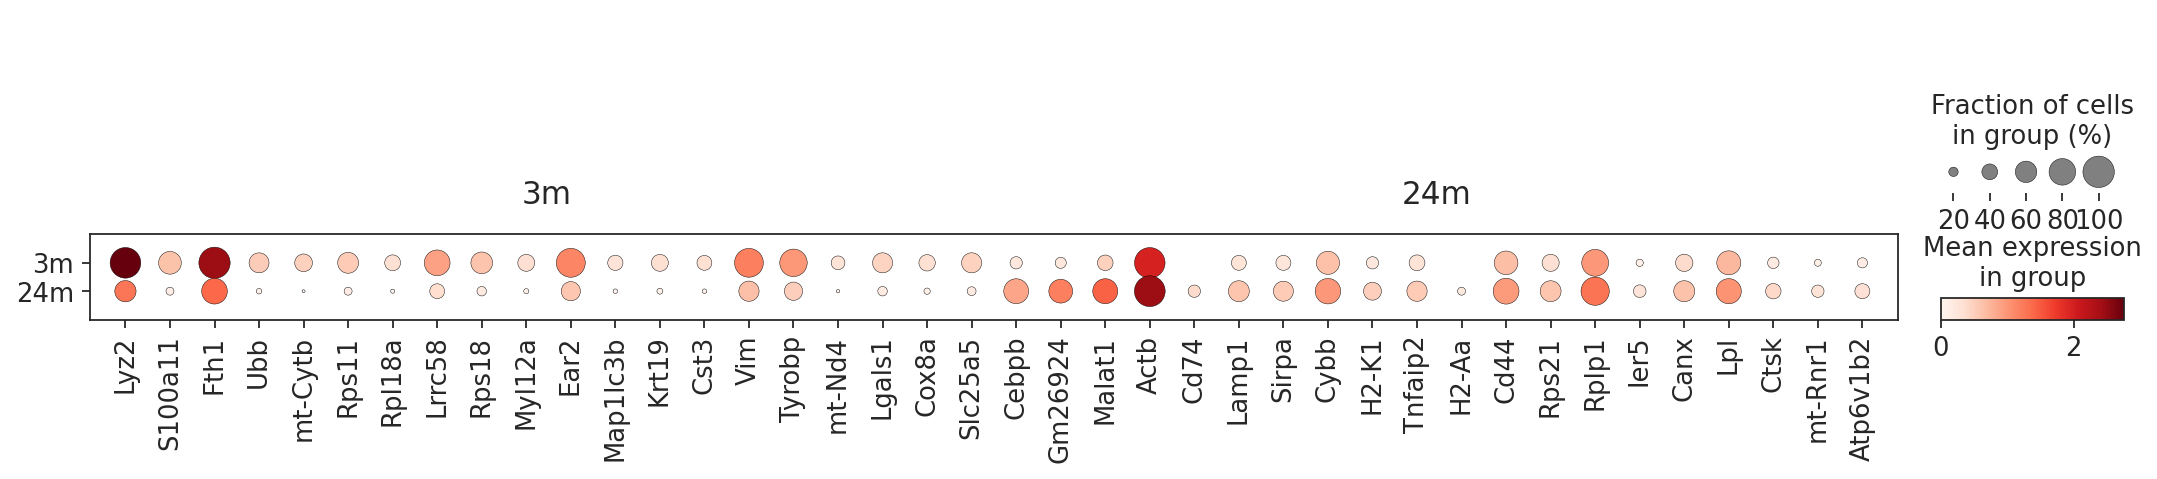

In [37]:
sc.tl.rank_genes_groups(sub, groupby = "grouping")
sc.pl.rank_genes_groups_dotplot(sub, n_genes = 20)

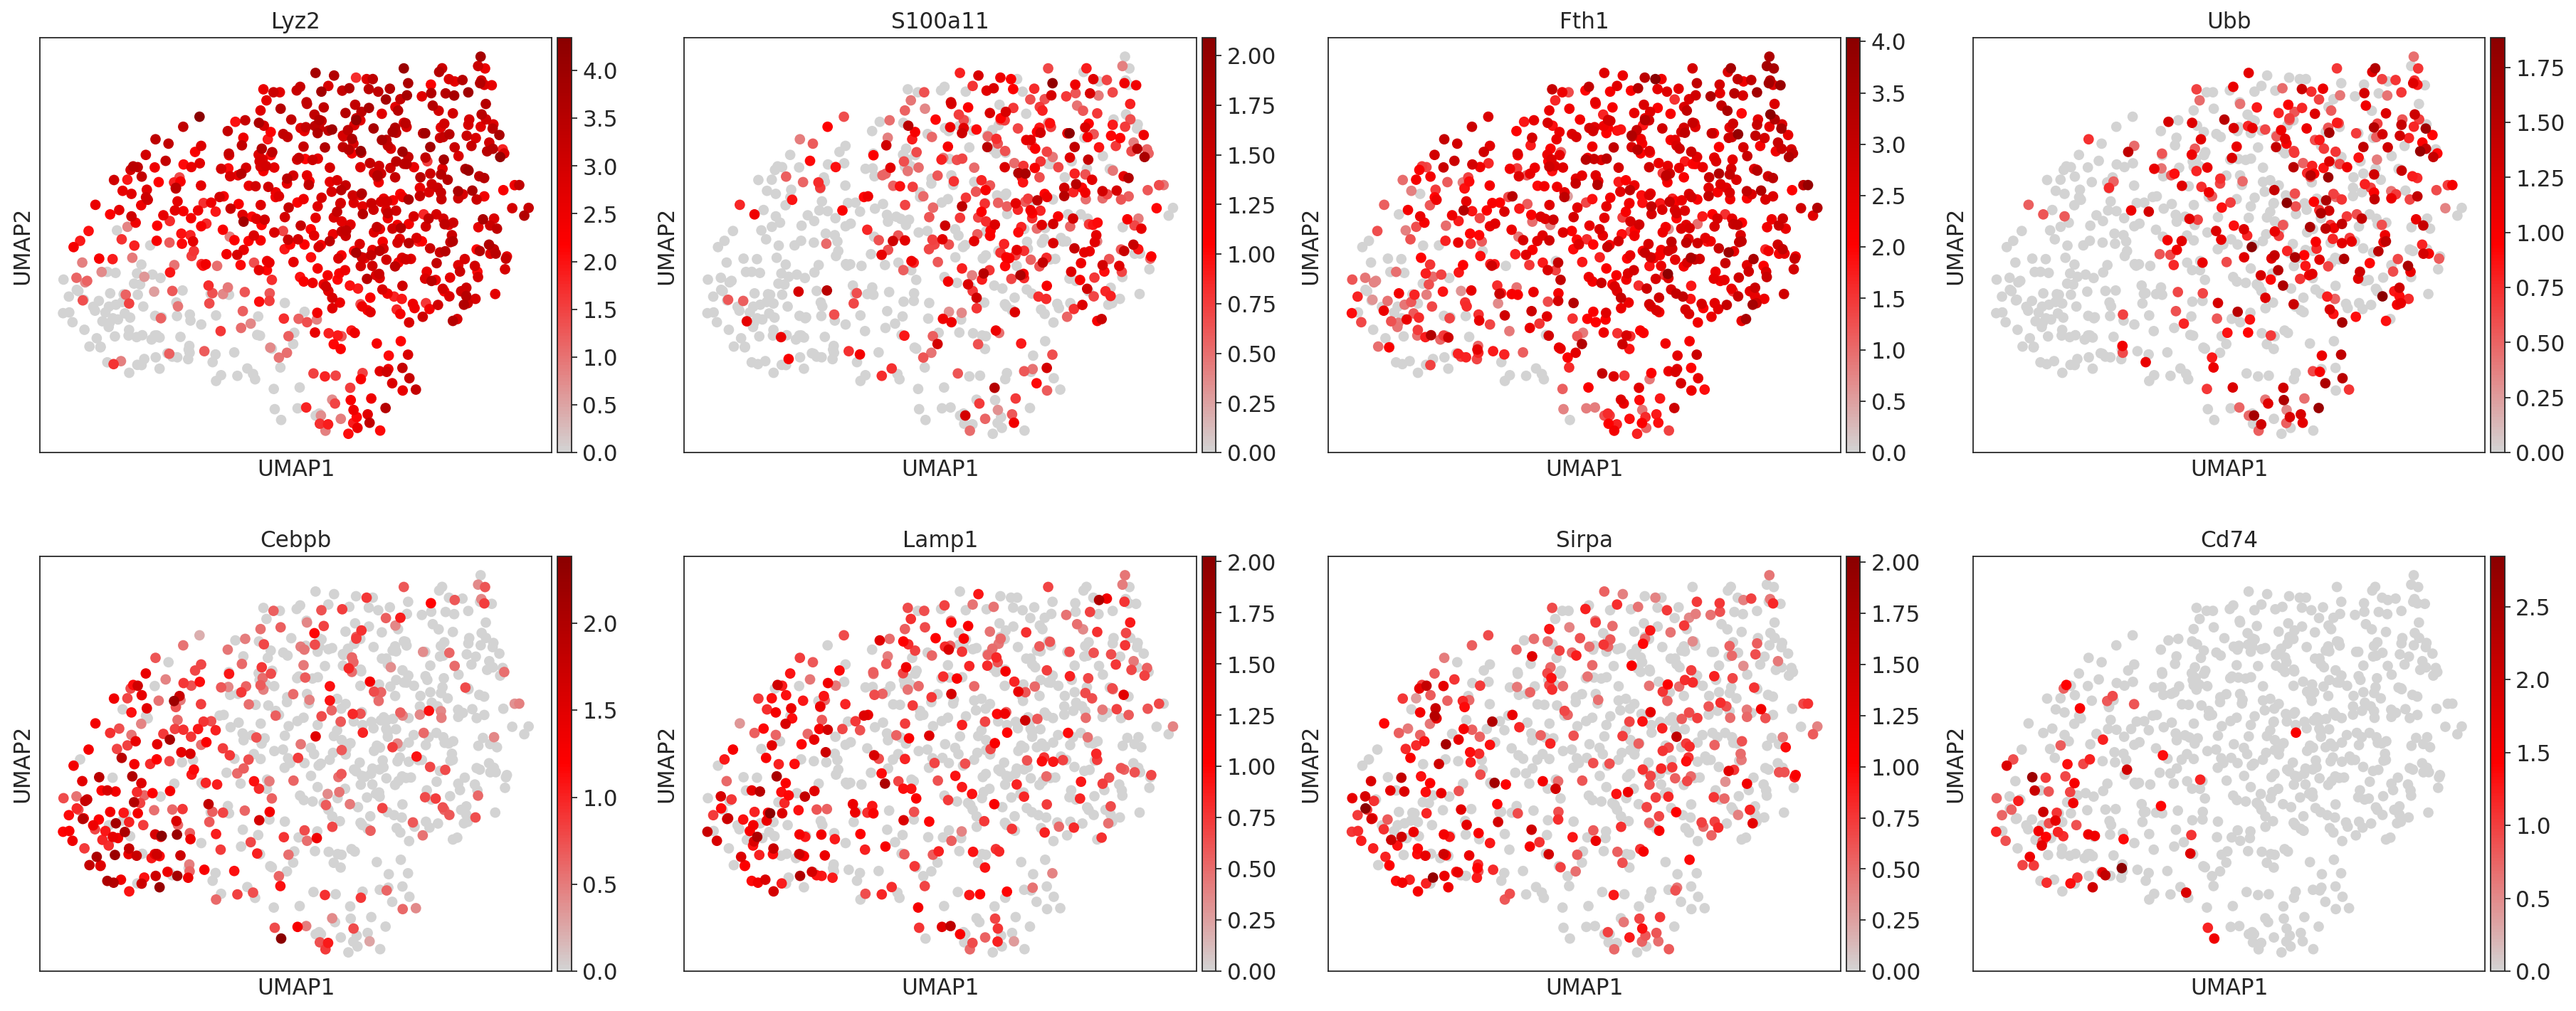

In [38]:
sc.pl.umap(sub, color = ["Lyz2", "S100a11", "Fth1", "Ubb", "Cebpb", "Lamp1", "Sirpa", "Cd74"], cmap = gray_red)

### Potential Bonus: PAGA
By quantifying the connectivity of partitions (groups, clusters) of the single-cell graph, partition-based graph abstraction (PAGA) generates a much simpler abstracted graph of partitions, in which edge weights represent confidence in the presence of connections. By tresholding this confidence in paga(), a much simpler representation of the manifold data is obtained.

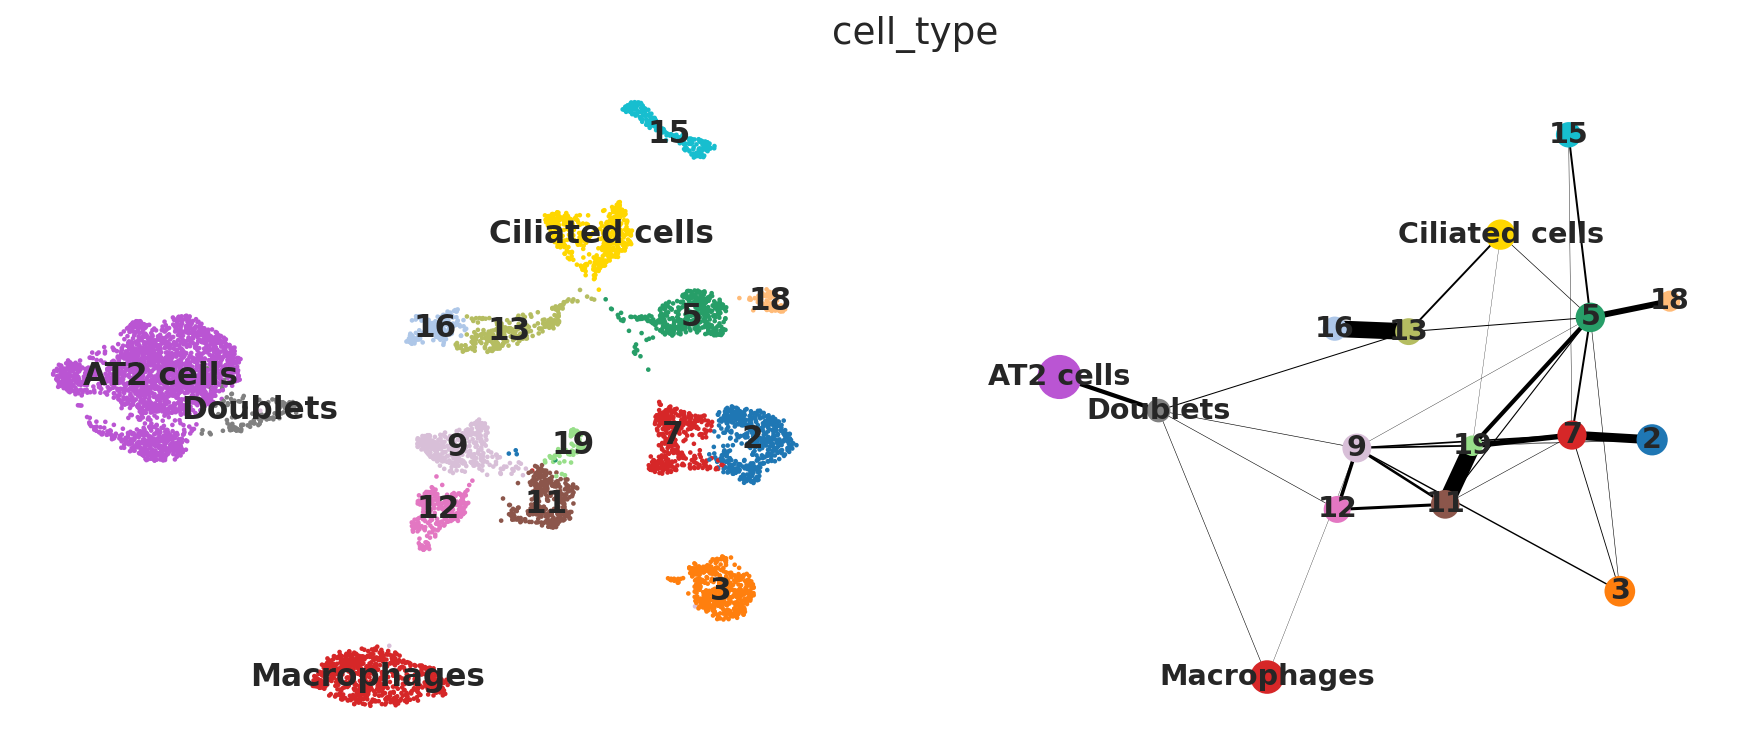

In [40]:
sc.tl.paga(adata, groups = "cell_type")
sc.pl.paga_compare(adata)

### In case you are curious, these were the final annotations

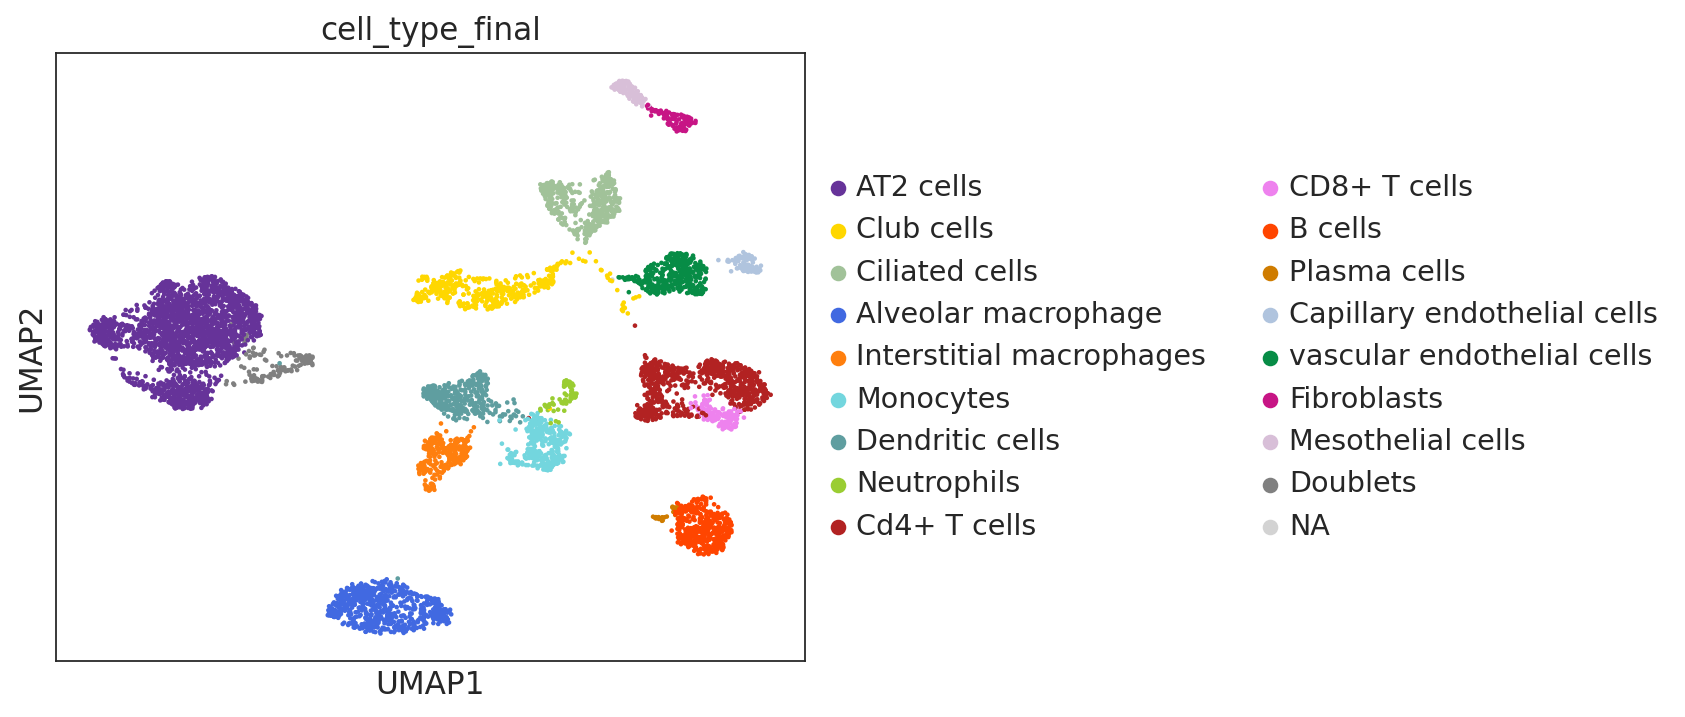

In [67]:
# tab = pd.read_csv("Data/cell_type_annotation.txt", sep = "\t", index_col = 0)
# adata.obs["cell_type_final"] = np.nan
# adata.obs["cell_type_final"].update(tab.cell_type_final)

# order = ['AT2 cells', 'Club cells', 'Ciliated cells', 'Alveolar macrophage', 'Interstitial macrophages', 
#          'Monocytes', 'Dendritic cells','Neutrophils', 'Cd4+ T cells', 'CD8+ T cells', 'B cells', 'Plasma cells', 
#          'Capillary endothelial cells', 'vascular endothelial cells', 'Fibroblasts', 'Mesothelial cells',
#          'Doublets']

# sc._utils.sanitize_anndata(adata)
# adata.obs.cell_type_automated.cat.reorder_categories(order, inplace = True)

# pal = ["rebeccapurple", "royalblue", "orangered", "violet", "lightsteelblue", "firebrick", "#A1C299", "gold", 
#        "cadetblue", "gray", "mediumvioletred", "tab:orange", "thistle", "#73d6de", "yellowgreen", 
#        "#cf7c00", "#078c46"]
# sc.pl.umap(adata, color = "cell_type_final", palette = pal)

In [44]:
adata

AnnData object with n_obs × n_vars = 6984 × 16963
    obs: 'batch', 'grouping', 'identifier', 'n_counts', 'n_genes', 'percent_mito', 'leiden_1', 'leiden_2', 'cell_type'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'identifier_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'grouping_colors', 'leiden', 'leiden_1_colors', 'leiden_2_colors', 'rank_genes_groups', 'dendrogram_leiden_1', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [58]:
## adata.write("Data/Aging_processed.h5ad")